### Further clean BALANCE variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.common import *
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
START = time.time()

### Setup

In [7]:
%%time
train = read_file(f"../{RAW_TRAIN_PARQUET_PATH}/balance.parquet")
test = read_file(f"../{RAW_TEST_PARQUET_PATH}/balance.parquet")

Shape of data: (5531451, 42)
Shape of data: (11363762, 42)
CPU times: user 5.67 s, sys: 13.7 s, total: 19.4 s
Wall time: 19.1 s


In [8]:
%%time
labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 986 ms, sys: 1.17 s, total: 2.15 s
Wall time: 4.03 s


In [9]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 3.25 s, sys: 4.47 s, total: 7.72 s
Wall time: 13.3 s


In [10]:
del test

In [11]:
train.shape, public_test.shape, private_test.shape

((5531451, 43), (5719469, 42), (5644293, 42))

In [12]:
df_list = [train, public_test, private_test]

In [13]:
print(sorted(get_cols(train, ["B_"])))

['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_2', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_3', 'B_30', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_4', 'B_40', 'B_41', 'B_42', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9']


In [14]:
train["target"].mean()

0.24909720794778803

In [15]:
for df in df_list:
    insert_row_number(df)

Done insertion
Done insertion
Done insertion


In [16]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_balance_corr.csv")
train_corr.index = train_corr.columns

Shape of data: (40, 40)


### B_723 (Created)

In [18]:
for df in df_list:
    df["B_723"] = (df["B_7"] + df["B_23"]).round(2)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


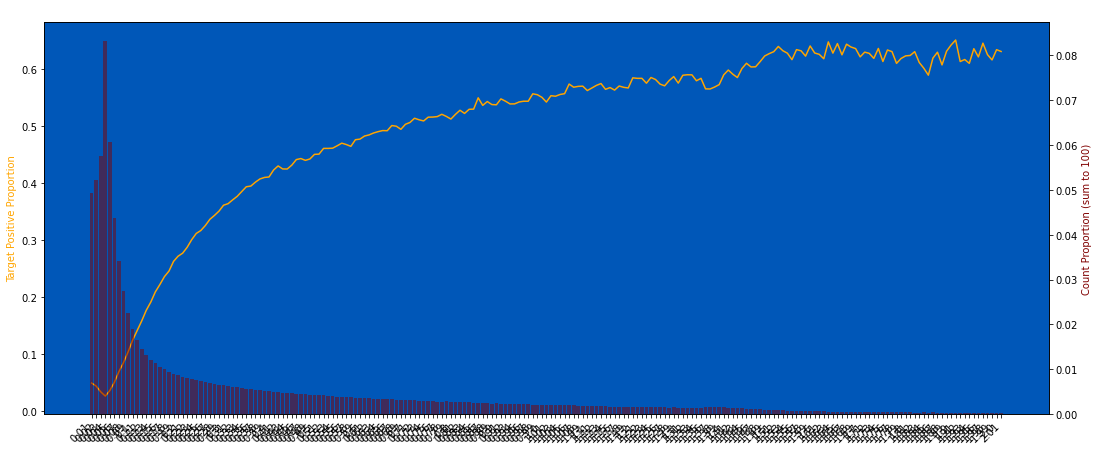

In [19]:
plot_target_check(train, "B_723", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

### B_111 (Created)

In [20]:
for df in df_list:
    df["B_111"] = sigmoid(df["B_1"] / df["B_11"] - 1)

In [21]:
df_list = round_dfs(df_list, col="B_111", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0028
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0025


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


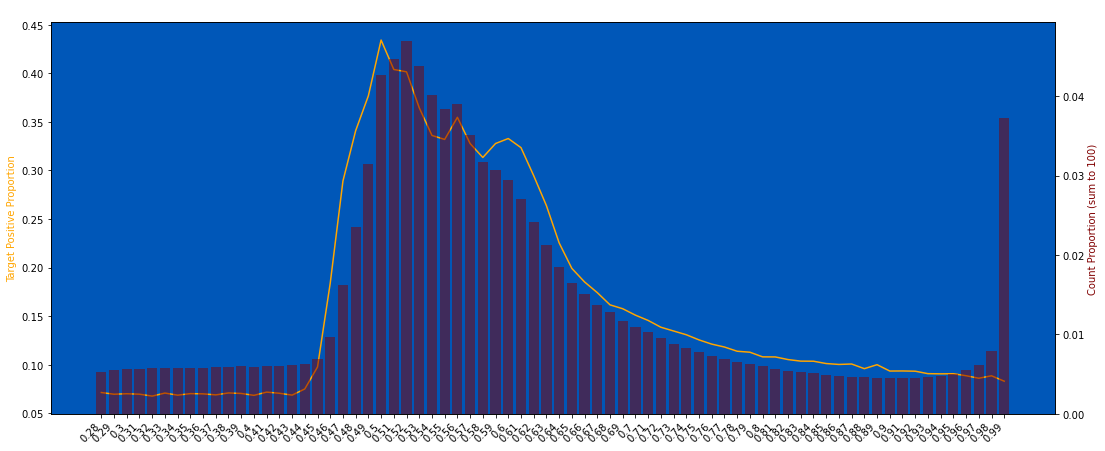

In [22]:
plot_target_check(train, "B_111", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0019, Train-Private PSI: 0.0025
Bottom 1% and Top 1% are dropped from this chart


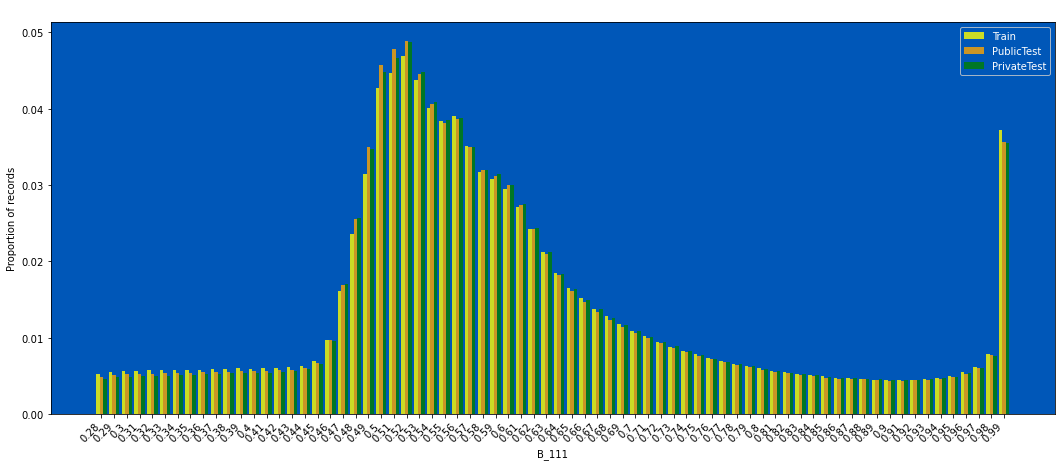

In [23]:
plot_train_test_distribution(df_list, "B_111", nunique_thr=8000)

### B_137 (Created)

In [24]:
for df in df_list:
    df["B_137"] = sigmoid(df["B_1"] / df["B_37"] - 1)

In [25]:
df_list = round_dfs(df_list, col="B_137", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0025
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0021


56 null count, 0.000 null proportion
0.1964 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


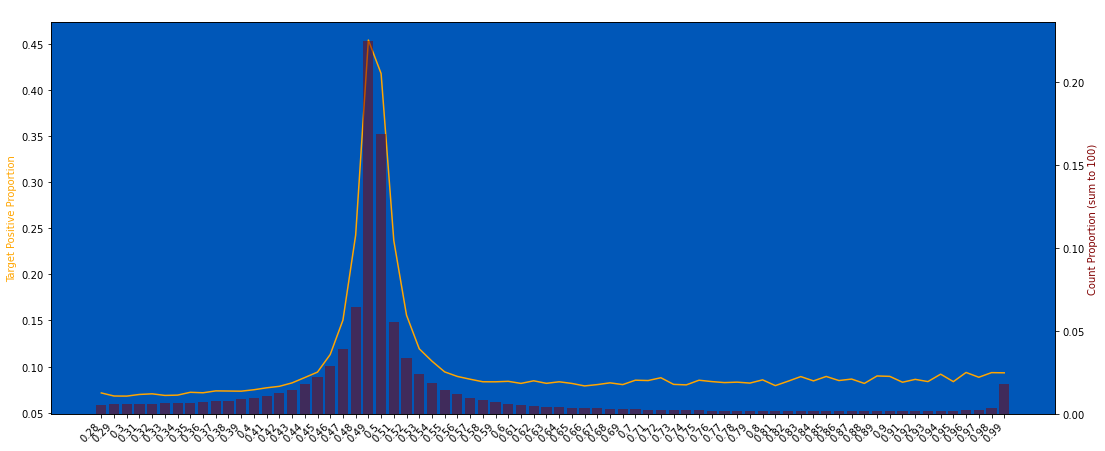

In [26]:
plot_target_check(train, "B_137", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [27]:
# plot_train_test_distribution(df_list, "B_137", nunique_thr=8000)

### B_1 (Done)

In [28]:
# plot_target_check(train, "B_1", q=50, use_raw_bin=True)

In [29]:
%%time
df_list = round_dfs(df_list, col="B_1", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0302
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0264
CPU times: user 2.67 s, sys: 2.69 s, total: 5.36 s
Wall time: 9.43 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


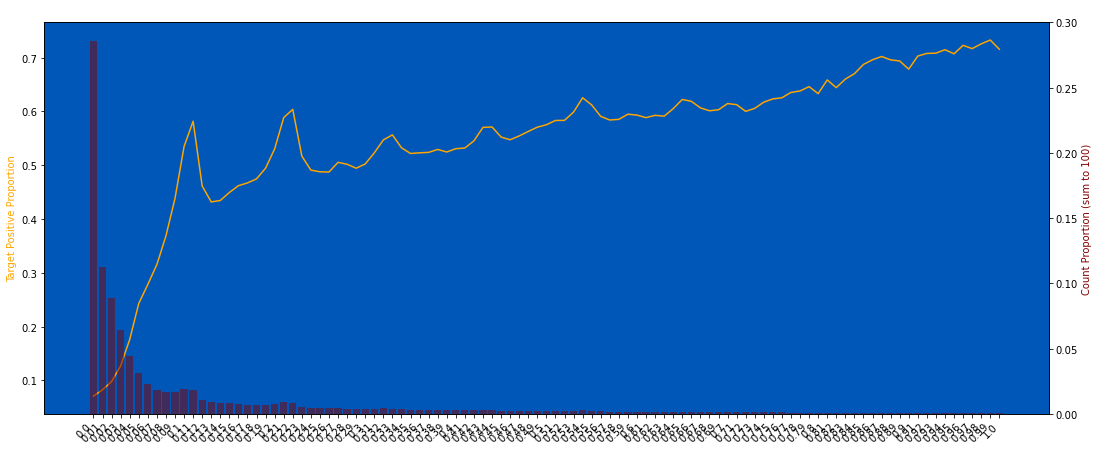

In [30]:
plot_target_check(train, "B_1", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0282, Train-Private PSI: 0.0264
Bottom 1% and Top 1% are dropped from this chart


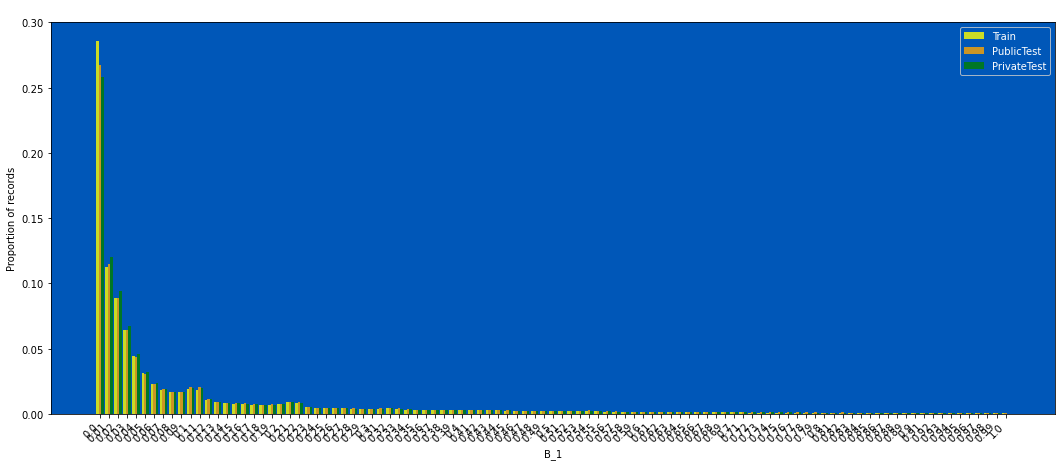

In [31]:
plot_train_test_distribution(df_list, "B_1", nunique_thr=8000)

### B_2 (Done)

In [32]:
# plot_target_check(train, "B_2", q=50, use_raw_bin=True)

In [33]:
%%time
df_list = round_dfs(df_list, col="B_2", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0109
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0107
CPU times: user 2.58 s, sys: 2.46 s, total: 5.04 s
Wall time: 9.08 s


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


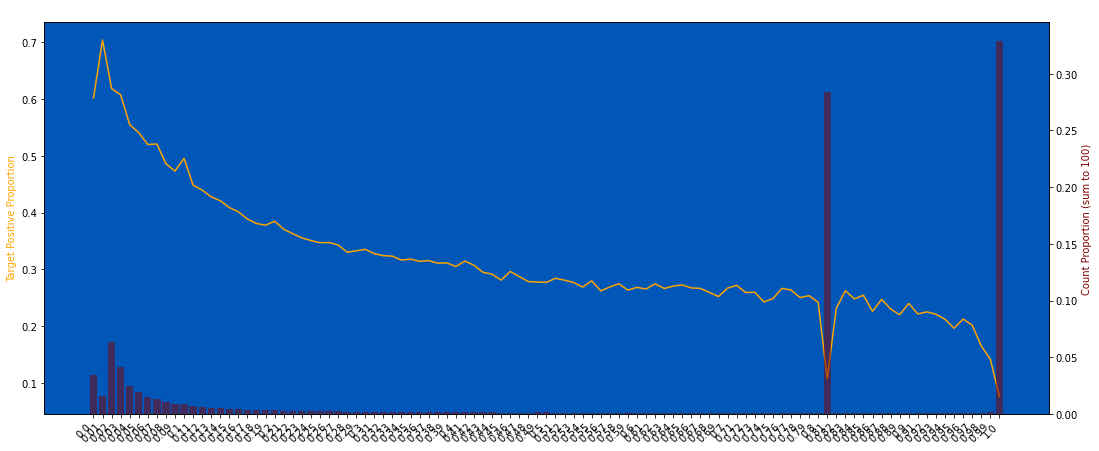

In [34]:
plot_target_check(train, "B_2", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

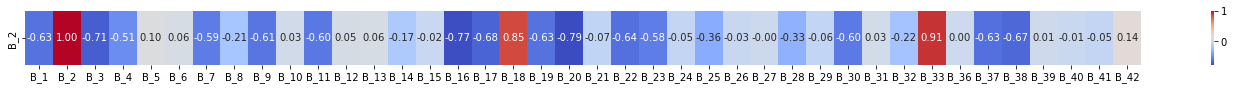

In [35]:
plot_heatmap(train_corr.loc[["B_2"], :], annot=True, fmt=".2f", figsize=(25, 1))

In [36]:
def get_weird_cid_list(df):
    b2_check_df = df.groupby("customer_ID")["B_2"].agg(["max", "min", "mean", "std"]).reset_index()
    b2_check_df["range"] = (b2_check_df["max"] - b2_check_df["min"]).round(2)
    sozi_cid_list = b2_check_df.loc[(b2_check_df["range"].isin([0, 0.19])) | (b2_check_df["min"].isin([0.81, 1]))].customer_ID.tolist()
    sozi_cid_list2 = b2_check_df.loc[(b2_check_df["range"].isin([0.81, 1]))].customer_ID.tolist()
    sozi_cid_list3 = b2_check_df.loc[(b2_check_df["max"] == 0.81) & (~b2_check_df["std"].between(0.15, 0.3))].customer_ID.tolist()
    sozi_cid_list4 = b2_check_df.loc[(b2_check_df["max"] == 1) & (~b2_check_df["std"].between(0.15, 0.49))].customer_ID.tolist()
    final_list = sozi_cid_list + sozi_cid_list2 + sozi_cid_list3 #+ sozi_cid_list4
    return final_list, b2_check_df

In [37]:
_, b2_check_df = get_weird_cid_list(train)

In [38]:
# plot_scatterplot(b2_check_df, "max", "std")

In [39]:
for df in tqdm(df_list):
    sozi_cid_list, _ = get_weird_cid_list(df)
    df.loc[(df["customer_ID"].isin(sozi_cid_list)) & (df["B_2"].isin([0.81, 1])), "B_2"] = 1.05
    df.loc[df["B_2"] == 0, "B_2"] = 0.01

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


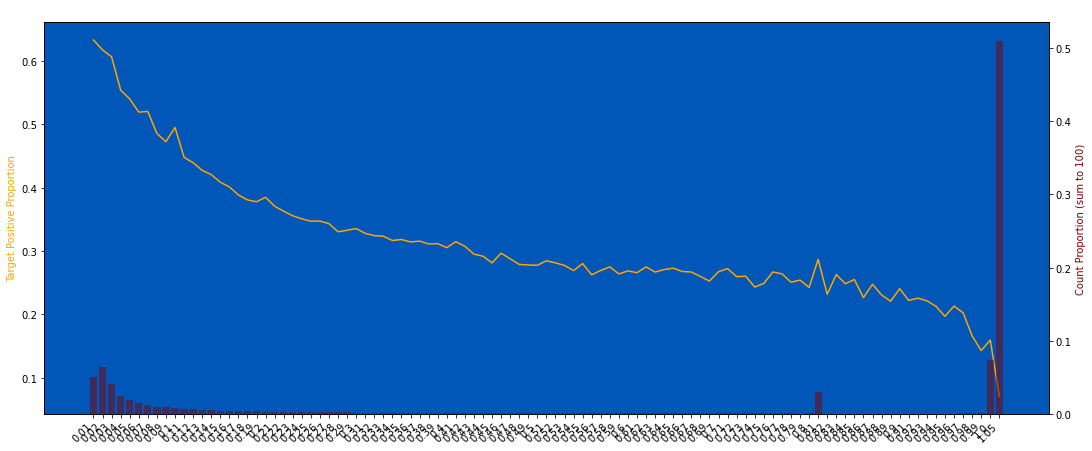

In [40]:
plot_target_check(train, "B_2", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [41]:
# plot_train_test_distribution(df_list, "B_2", nunique_thr=8000, without_drop_tail=True)

### B_3 (Done)

In [43]:
# plot_target_check(train, "B_3", q=50, use_raw_bin=True)

In [44]:
%%time
df_list = round_dfs(df_list, col="B_3", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0340
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0063
CPU times: user 2.58 s, sys: 2.4 s, total: 4.98 s
Wall time: 7.93 s


In [45]:
# plot_target_check(train, "B_3", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

In [46]:
# plot_train_test_distribution(df_list, "B_3", nunique_thr=8000)

### B_4 (Done)

In [47]:
# plot_target_check(train, "B_4", q=50, use_raw_bin=True, nunique_thr=1000)

In [48]:
%%time
df_list = round_dfs(df_list, col="B_4", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0239
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0255
CPU times: user 2.54 s, sys: 2.13 s, total: 4.66 s
Wall time: 7.3 s


In [49]:
# plot_target_check(train, "B_4", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

In [50]:
# plot_train_test_distribution(df_list, "B_4", nunique_thr=8000)

### B_5 (Done)

In [51]:
# plot_target_check(train, "B_5", q=50, use_raw_bin=True)

In [52]:
%%time
df_list = round_dfs(df_list, col="B_5", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0659
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0646
CPU times: user 2.49 s, sys: 2.08 s, total: 4.57 s
Wall time: 7.09 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


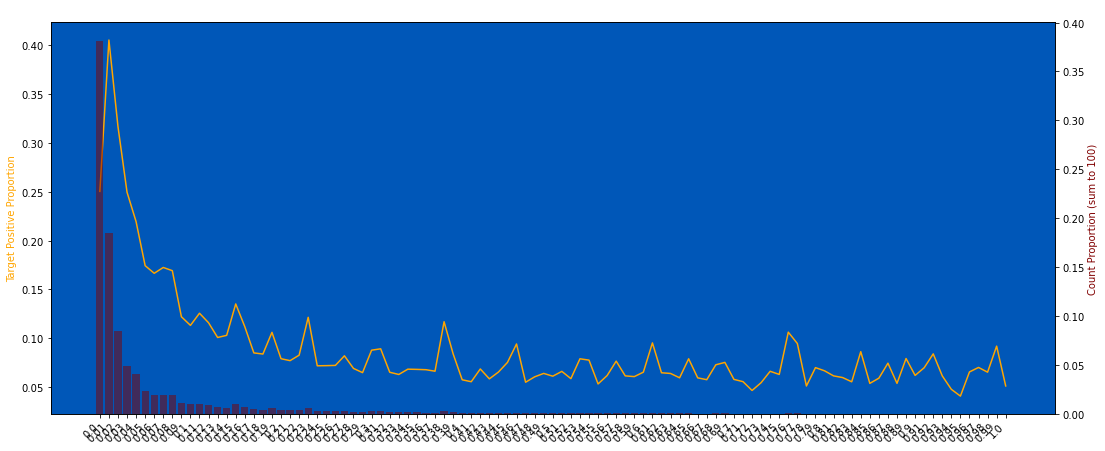

In [53]:
plot_target_check(train, "B_5", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

In [54]:
def get_weird_cid_list_b5(df):
    b5_check_df = df.groupby("customer_ID")["B_5"].agg(["max", "min", "mean", "std"]).reset_index()
    sozi_cid_list = b5_check_df.loc[b5_check_df["max"] == 0].customer_ID.tolist()
    return sozi_cid_list, b5_check_df

In [55]:
for df in tqdm(df_list):
    sozi_cid_list, _ = get_weird_cid_list_b5(df)
    df.loc[(df["customer_ID"].isin(sozi_cid_list)) & (df["B_5"] == 0), "B_5"] = np.nan

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


782660 null count, 0.141 null proportion
0.0832 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


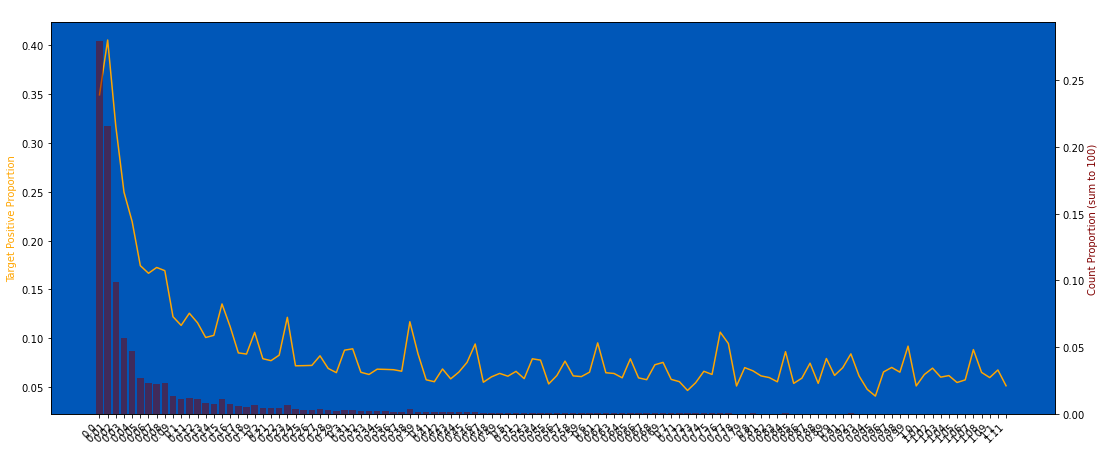

In [56]:
plot_target_check(train, "B_5", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

Train-Public PSI: 0.0813, Train-Private PSI: 0.0653
Bottom 1% and Top 1% are dropped from this chart


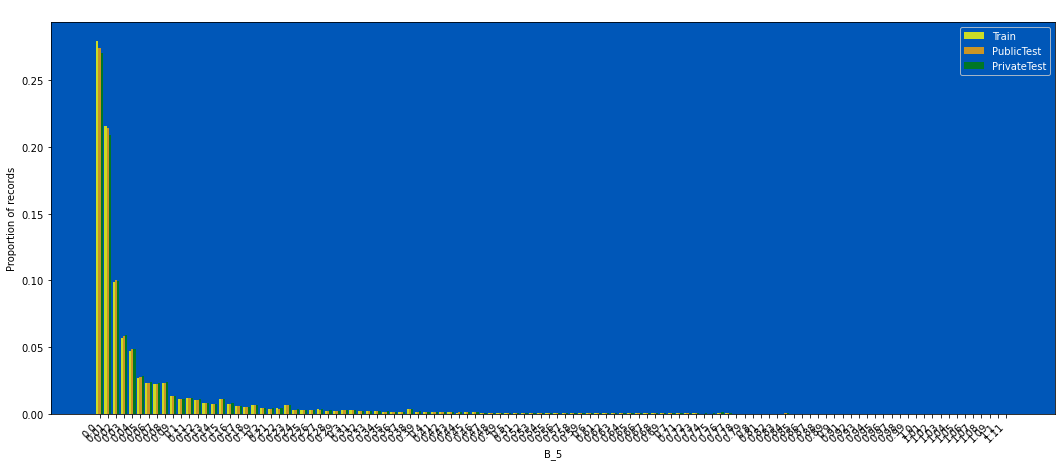

In [57]:
plot_train_test_distribution(df_list, "B_5", nunique_thr=8000)

In [58]:
check_psi(df_list, "B_5")

(0.0813395133259682, 0.06532314441073879)

### B_6 (KIV)

In [59]:
# plot_target_check(train, "B_6", q=50, use_raw_bin=True)

In [60]:
def get_weird_cid_list_b6(df):
    c = df.groupby("customer_ID")["B_6"].agg(["max", "min", "mean", "std"]).reset_index()
    sozi_cid_list1 = c.loc[(c["max"] > 1.5) & (c["min"].between(0.17, 0.19))].customer_ID.tolist()
    sozi_cid_list2 = c.loc[(c["min"] < 0.1) & (c["max"].between(0.17, 0.19))].customer_ID.tolist()
    sozi_cid_list = sozi_cid_list1 + sozi_cid_list2
    return sozi_cid_list, c

In [61]:
for df in tqdm(df_list):
    sozi_cid_list, _ = get_weird_cid_list_b6(df)
    df.loc[(df["customer_ID"].isin(sozi_cid_list)) & (df["B_6"].between(0.17, 0.19)), "B_6"] = np.nan

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.08s/it]


In [62]:
%%time
df_list = round_dfs(df_list, col="B_6", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0468
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0473
CPU times: user 2.53 s, sys: 2.6 s, total: 5.12 s
Wall time: 8.51 s


63385 null count, 0.011 null proportion
0.3751 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


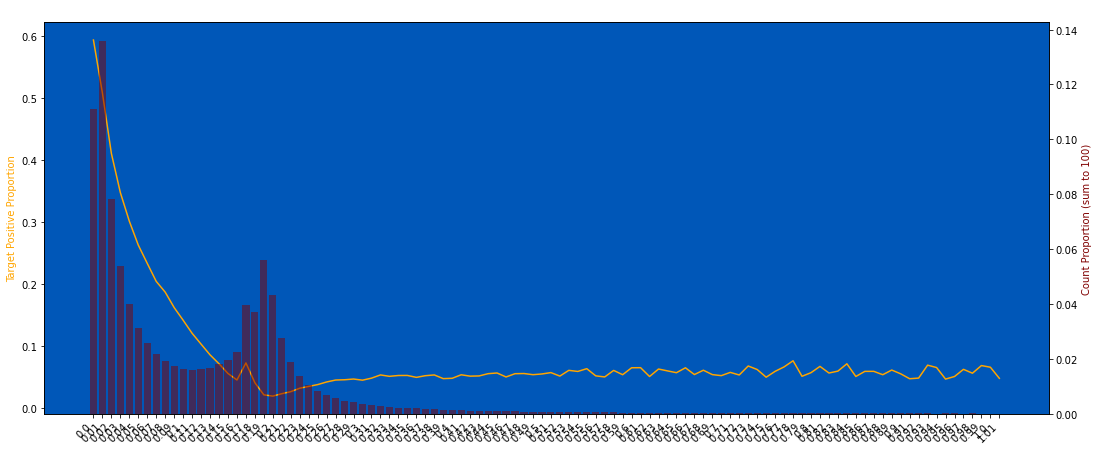

In [63]:
plot_target_check(train, "B_6", q=50, use_raw_bin=True, nunique_thr=7200, strfy_x=True)

Train-Public PSI: 0.0464, Train-Private PSI: 0.0473
Bottom 1% and Top 1% are dropped from this chart


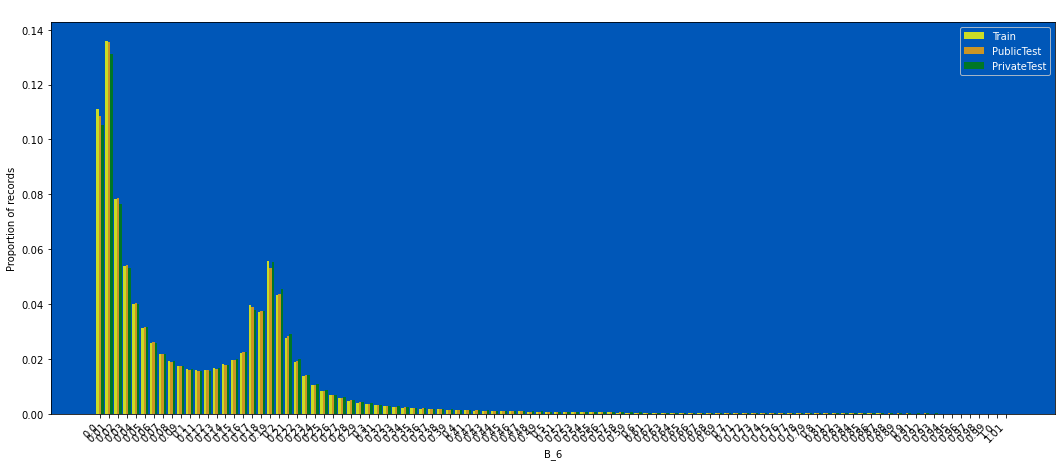

In [64]:
plot_train_test_distribution(df_list, "B_6", nunique_thr=8000)

In [65]:
check_psi(df_list, "B_6")

(0.046409601238791384, 0.047273639420931136)

### B_7 (KIV)

In [66]:
# plot_target_check(train, "B_7", q=50, use_raw_bin=True)

In [67]:
%%time
df_list = round_dfs(df_list, col="B_7", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0305
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0178
CPU times: user 2.59 s, sys: 2.16 s, total: 4.75 s
Wall time: 7.37 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


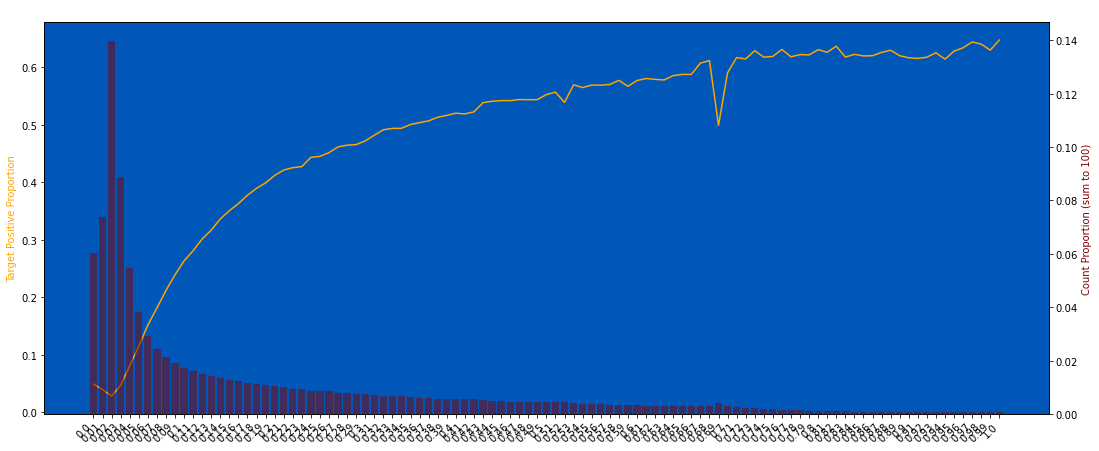

In [68]:
plot_target_check(train, "B_7", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Train-Public PSI: 0.0168, Train-Private PSI: 0.0178
Bottom 1% and Top 1% are dropped from this chart


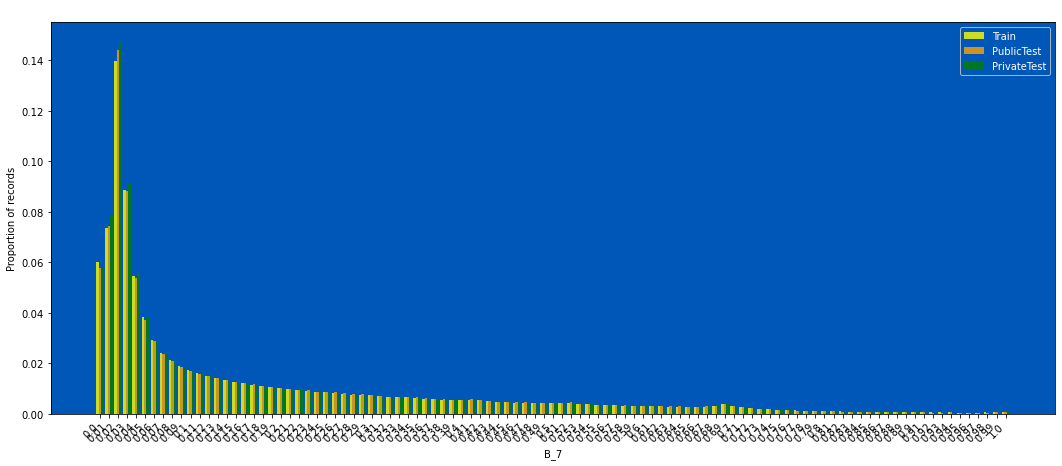

In [69]:
plot_train_test_distribution(df_list, "B_7", nunique_thr=8000)

In [70]:
check_psi(df_list, "B_7")

(0.01678444470462067, 0.017761748554662556)

### B_8 (Done)

In [71]:
# plot_target_check(train, "B_8", q=50, use_raw_bin=True)

In [72]:
%%time
df_list = round_dfs(df_list, col="B_8", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0073
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0061
CPU times: user 2.32 s, sys: 1.81 s, total: 4.13 s
Wall time: 6.07 s


In [73]:
train["B_8"].value_counts()

0.0000    3053857
1.0000    2399757
0.9900      54735
1.0100        834
Name: B_8, dtype: int64

In [74]:
train.groupby(["B_8"])["target"].mean()

B_8
0.0000   0.1233
0.9900   0.3732
1.0000   0.4057
1.0100   0.6547
Name: target, dtype: float64

In [75]:
for df in df_list:
    df["B_8"] = df["B_8"].round(0)

In [76]:
# plot_target_check(train, "B_8", q=50, use_raw_bin=True)

Train-Public PSI: 0.0083, Train-Private PSI: 0.0061
Bottom 1% and Top 1% are dropped from this chart


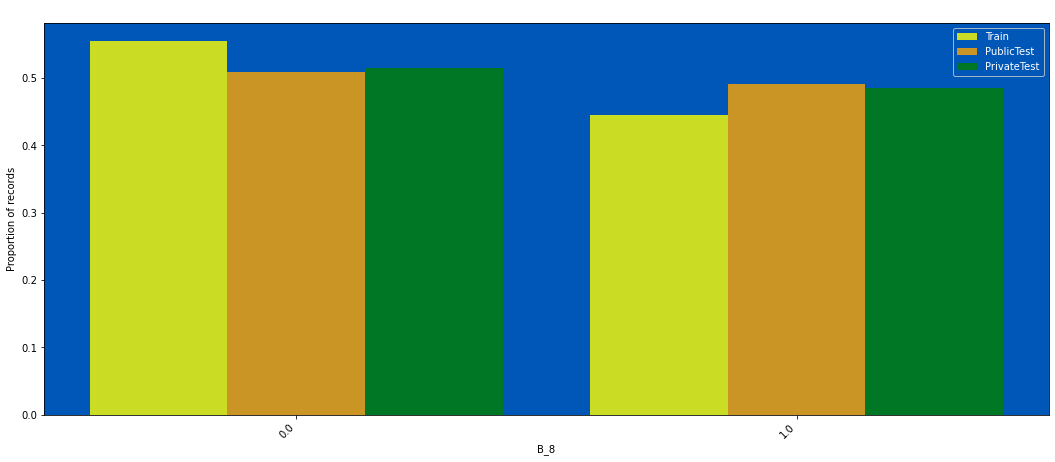

In [77]:
plot_train_test_distribution(df_list, "B_8", nunique_thr=8000)

In [78]:
check_psi(df_list, "B_8")

(0.008303166552093712, 0.0061072513713317424)

### B_9

In [79]:
# plot_target_check(train, "B_9", q=50, use_raw_bin=True)

In [80]:
%%time
df_list = round_dfs(df_list, col="B_9", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1149
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1200
CPU times: user 2.44 s, sys: 1.98 s, total: 4.42 s
Wall time: 6.95 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


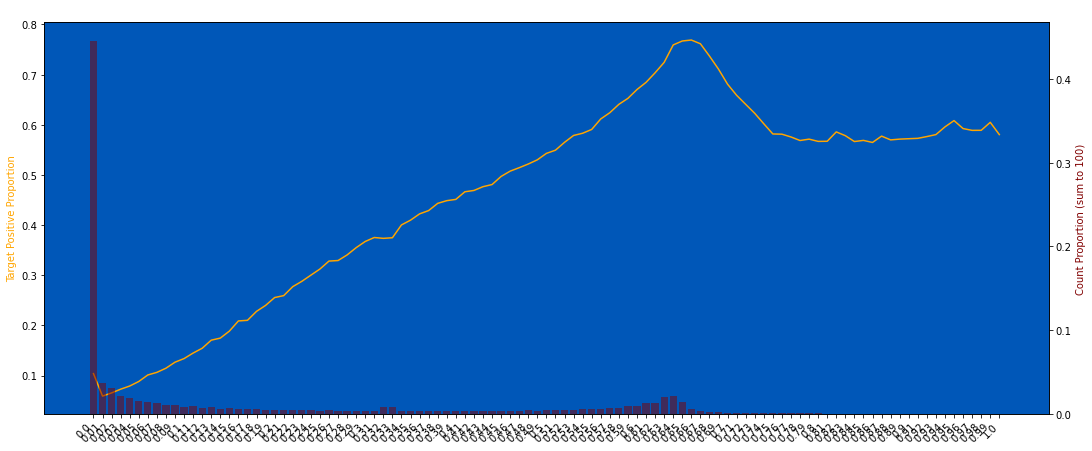

In [81]:
plot_target_check(train, "B_9", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True)

Train-Public PSI: 0.0978, Train-Private PSI: 0.1200
Bottom 1% and Top 1% are dropped from this chart


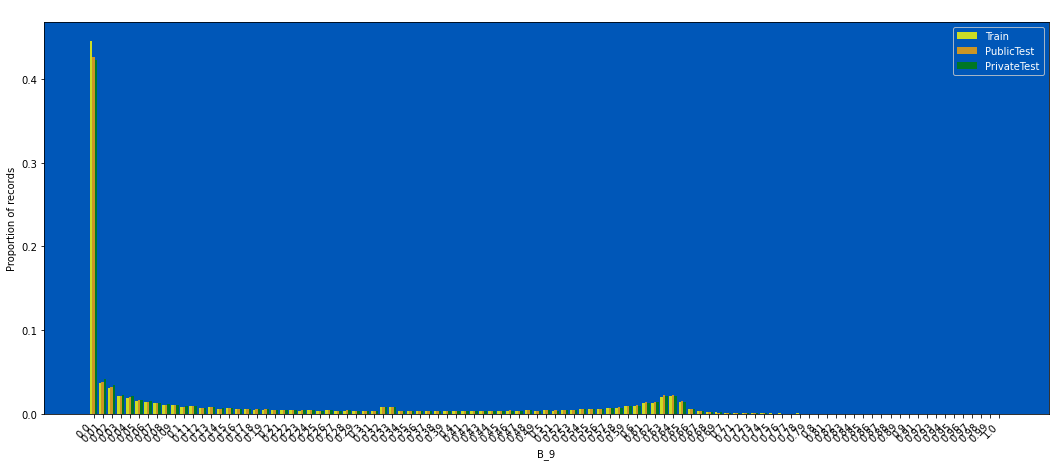

In [82]:
plot_train_test_distribution(df_list, "B_9", nunique_thr=8000)

### B_10

In [83]:
# plot_target_check(train, "B_10", q=50, use_raw_bin=True)

In [84]:
%%time
df_list = round_dfs(df_list, col="B_10", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0669
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0669
CPU times: user 2.46 s, sys: 1.93 s, total: 4.39 s
Wall time: 6.63 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


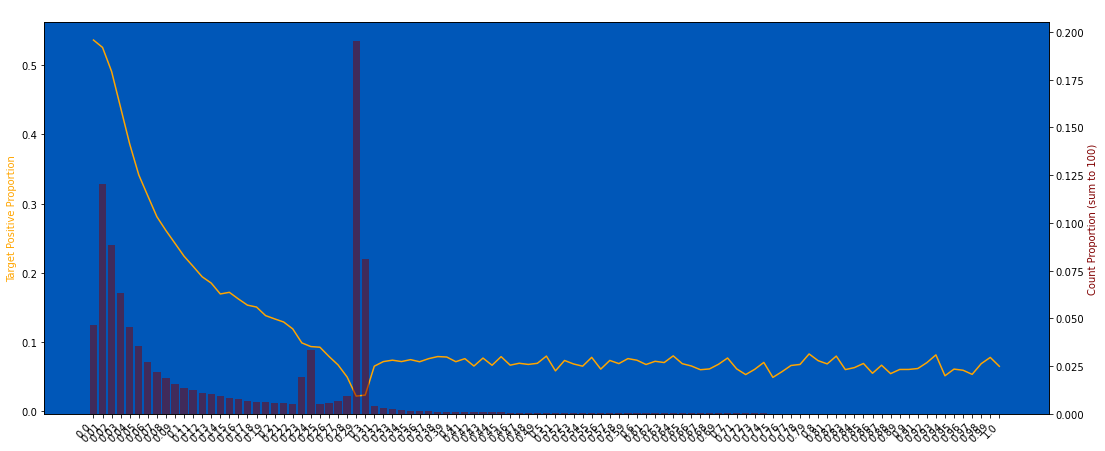

In [85]:
b10_summary = plot_target_check(train, "B_10", q=50, use_raw_bin=True, nunique_thr=7000, strfy_x=True, return_df=True)

Train-Public PSI: 0.0527, Train-Private PSI: 0.0669
Bottom 1% and Top 1% are dropped from this chart


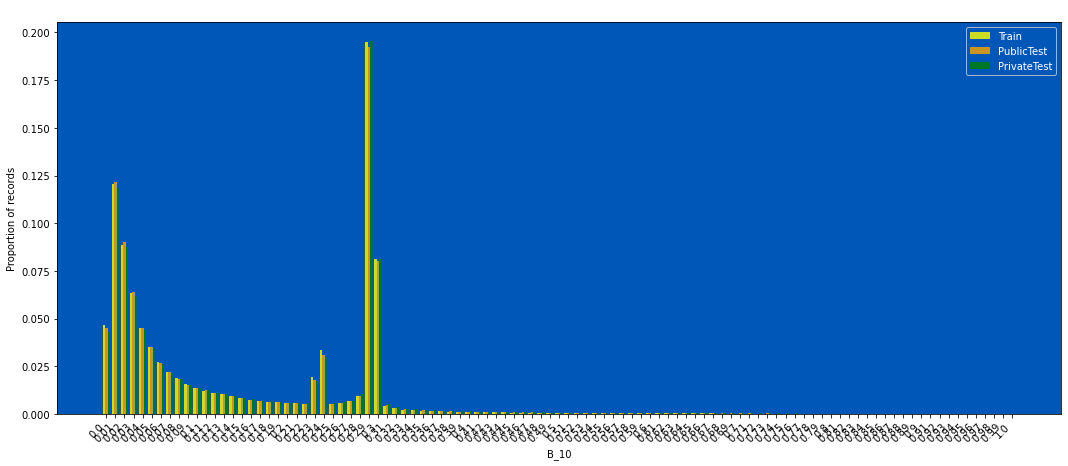

In [86]:
plot_train_test_distribution(df_list, "B_10", nunique_thr=8000)

### B_11

In [87]:
# plot_target_check(train, "B_11", q=50, use_raw_bin=True)

In [88]:
%%time
df_list = round_dfs(df_list, col="B_11", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0198
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0075
CPU times: user 2.47 s, sys: 2.11 s, total: 4.59 s
Wall time: 6.79 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


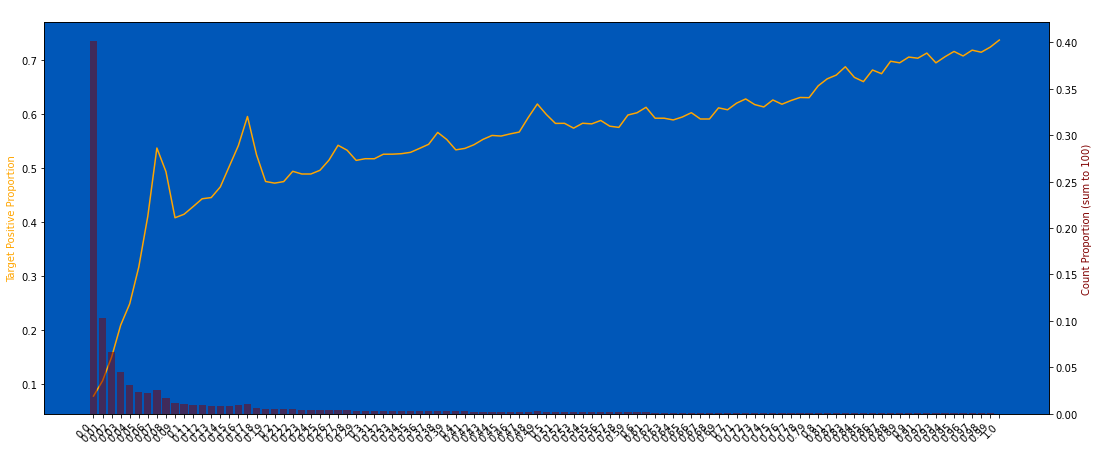

In [89]:
plot_target_check(train, "B_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0090, Train-Private PSI: 0.0075
Bottom 1% and Top 1% are dropped from this chart


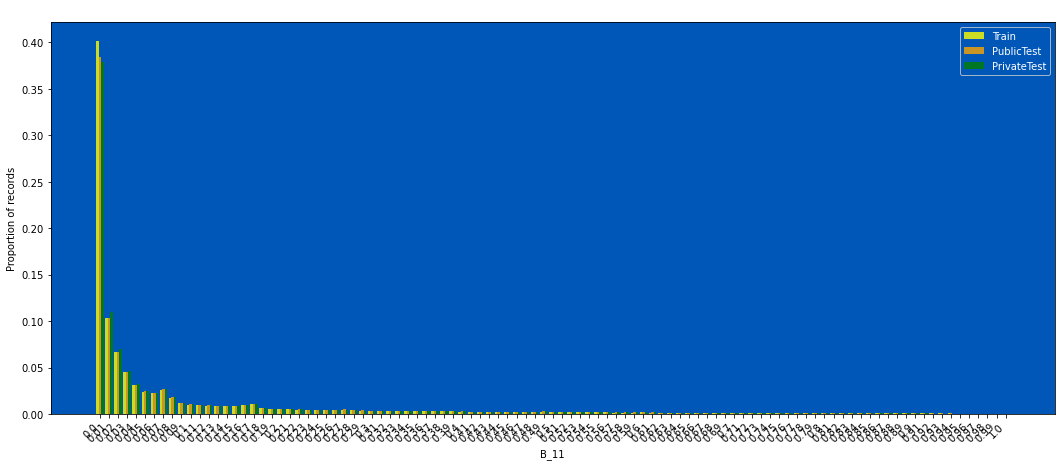

In [90]:
plot_train_test_distribution(df_list, "B_11", nunique_thr=8000)

### B_12

In [91]:
# plot_target_check(train, "B_12", q=50, use_raw_bin=True)

In [92]:
%%time
df_list = round_dfs(df_list, col="B_12", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0545
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0545
CPU times: user 2.37 s, sys: 2.05 s, total: 4.42 s
Wall time: 7.07 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


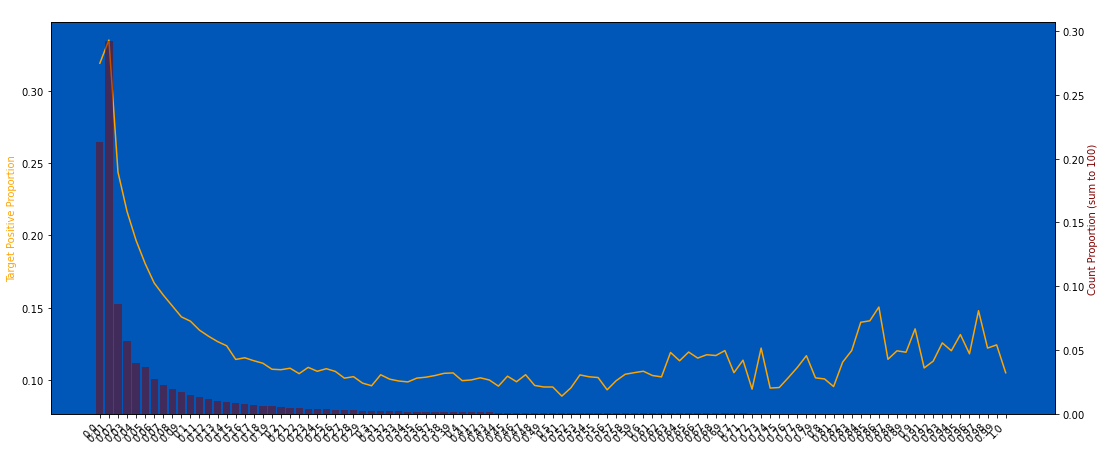

In [93]:
plot_target_check(train, "B_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0702, Train-Private PSI: 0.0545
Bottom 1% and Top 1% are dropped from this chart


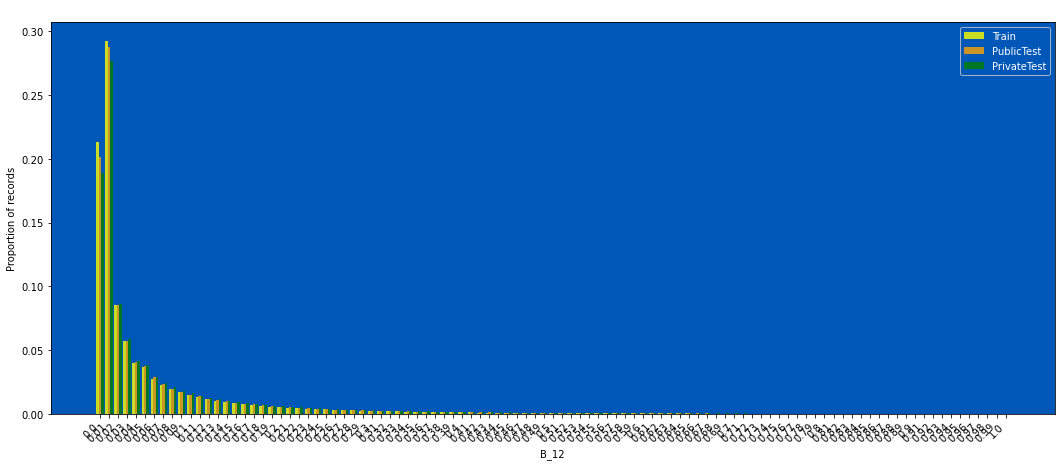

In [94]:
plot_train_test_distribution(df_list, "B_12", nunique_thr=8000)

### B_13

In [95]:
# plot_target_check(train, "B_13", q=50, use_raw_bin=True)

In [96]:
%%time
df_list = round_dfs(df_list, col="B_13", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0506
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0492
CPU times: user 2.4 s, sys: 1.83 s, total: 4.23 s
Wall time: 6.17 s


49519 null count, 0.009 null proportion
0.4906 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


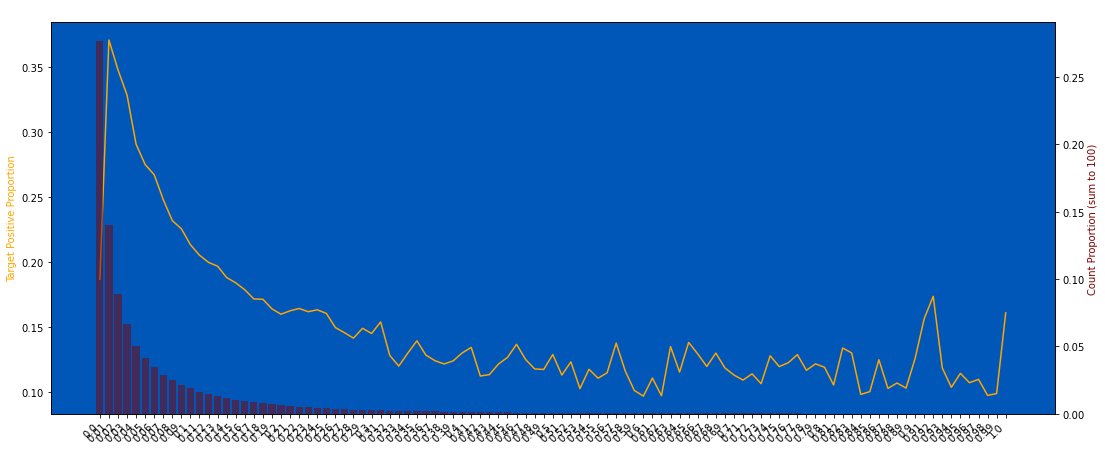

In [97]:
plot_target_check(train, "B_13", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0454, Train-Private PSI: 0.0492
Bottom 1% and Top 1% are dropped from this chart


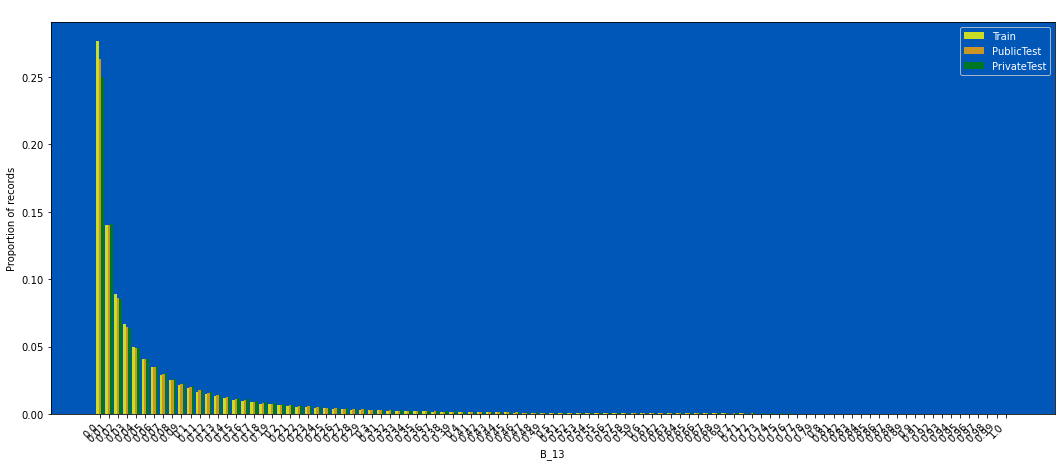

In [98]:
plot_train_test_distribution(df_list, "B_13", nunique_thr=8000)

### B_14

In [99]:
# plot_target_check(train, "B_14", q=50, use_raw_bin=True)

In [100]:
%%time
df_list = round_dfs(df_list, col="B_14", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0929
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0936
CPU times: user 2.42 s, sys: 1.68 s, total: 4.1 s
Wall time: 5.98 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


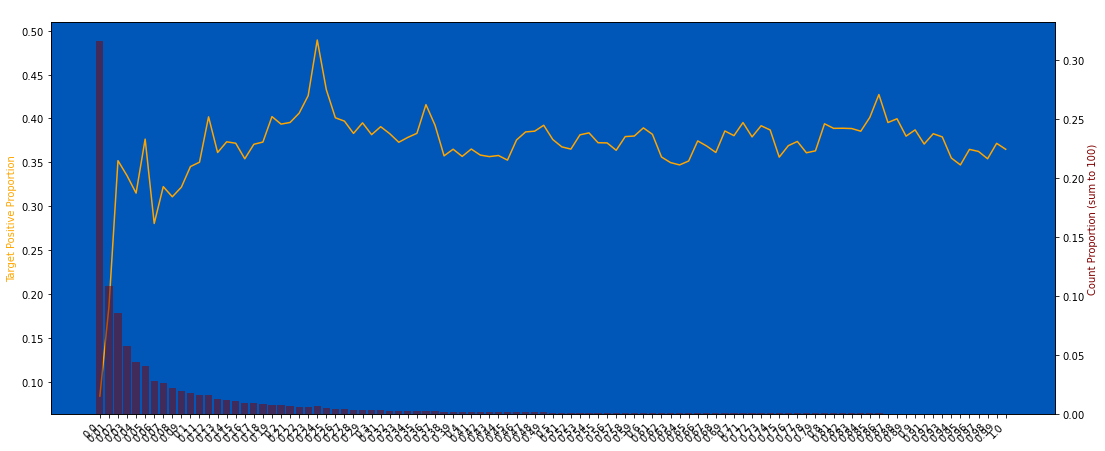

In [101]:
plot_target_check(train, "B_14", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0971, Train-Private PSI: 0.0936
Bottom 1% and Top 1% are dropped from this chart


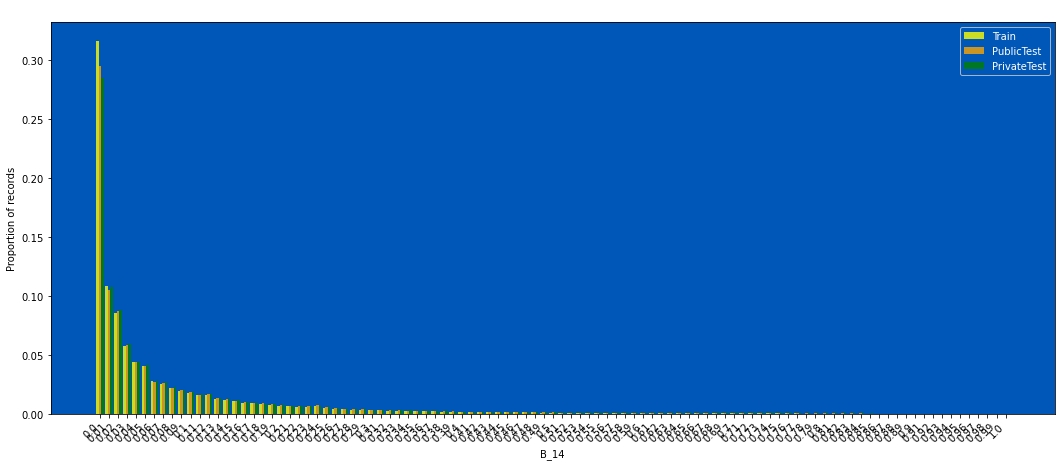

In [102]:
plot_train_test_distribution(df_list, "B_14", nunique_thr=8000)

### B_15

In [103]:
# plot_target_check(train, "B_15", q=50, use_raw_bin=True)

In [104]:
%%time
df_list = round_dfs(df_list, col="B_15", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0823
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0835
CPU times: user 2.35 s, sys: 1.63 s, total: 3.98 s
Wall time: 5.85 s


6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


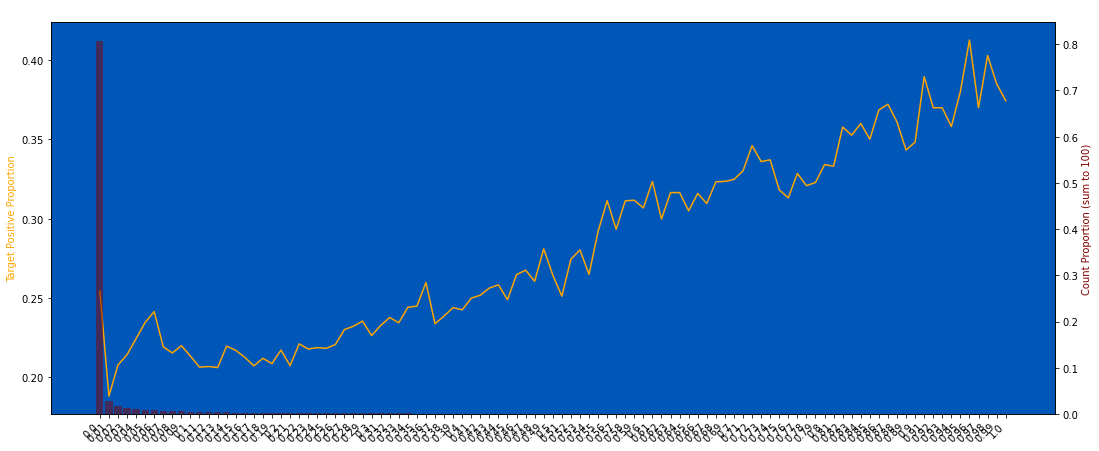

In [105]:
plot_target_check(train, "B_15", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True)

Train-Public PSI: 0.0863, Train-Private PSI: 0.0835
Bottom 1% and Top 1% are dropped from this chart


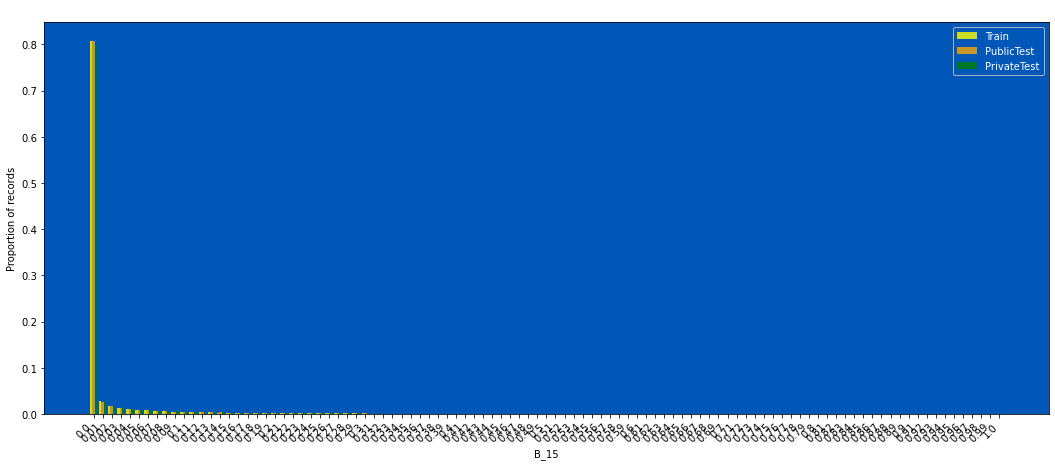

In [106]:
plot_train_test_distribution(df_list, "B_15", nunique_thr=8000)

### B_16

In [107]:
# plot_target_check(train, "B_16", q=50, use_raw_bin=True)

In [108]:
%%time
df_list = round_dfs(df_list, col="B_16", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0040
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0040
CPU times: user 2.41 s, sys: 1.59 s, total: 4 s
Wall time: 5.98 s


In [112]:
for df in df_list:
    df["B_16"] = (df["B_16"] / 0.083).round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


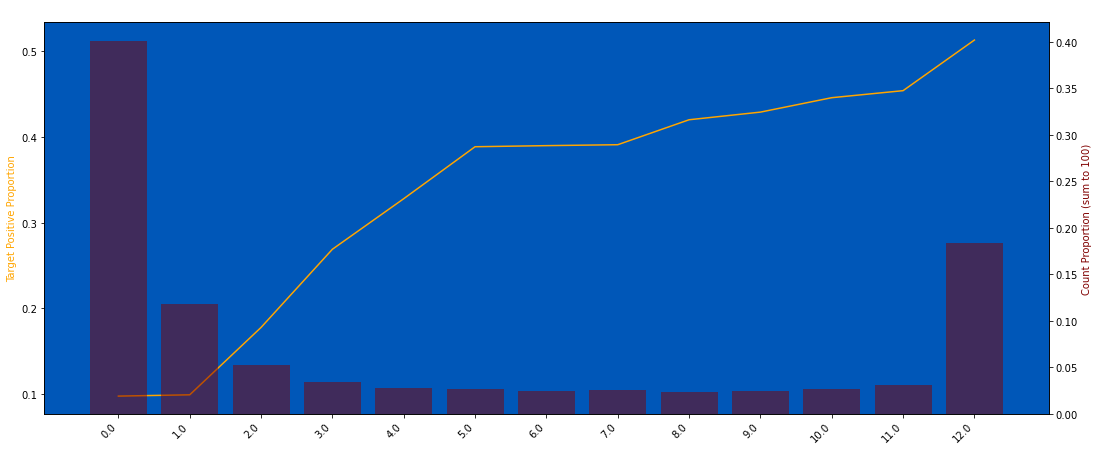

In [113]:
plot_target_check(train, "B_16", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0029, Train-Private PSI: 0.0040
Bottom 1% and Top 1% are dropped from this chart


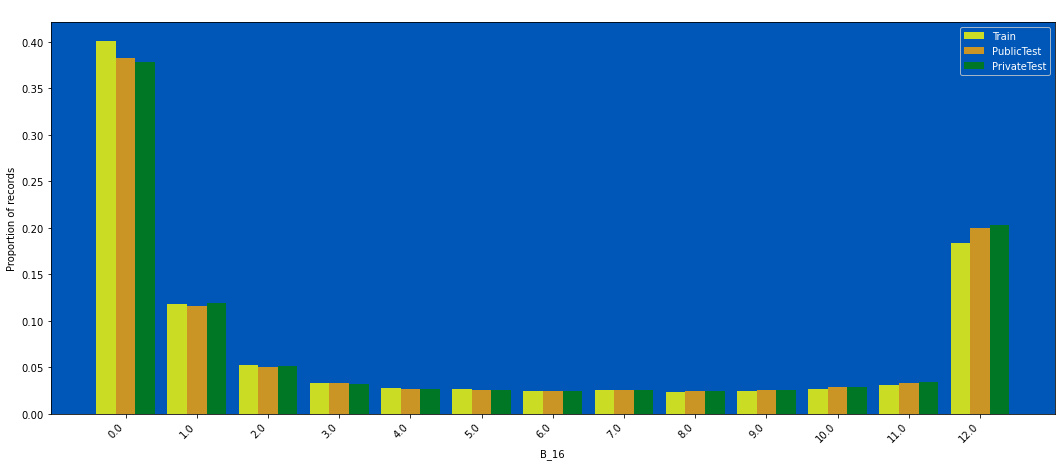

In [114]:
plot_train_test_distribution(df_list, "B_16", nunique_thr=8000)

### B_17

In [115]:
# plot_target_check(train, "B_17", q=50, use_raw_bin=True)

In [116]:
%%time
df_list = round_dfs(df_list, col="B_17", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0044
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0040
CPU times: user 2.18 s, sys: 1.81 s, total: 3.99 s
Wall time: 5.51 s


3137598 null count, 0.567 null proportion
0.1226 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


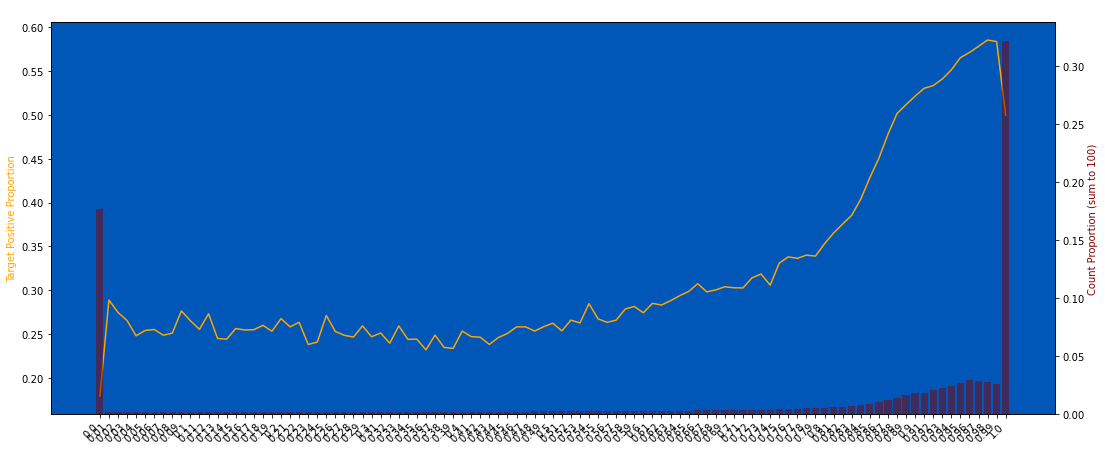

In [117]:
plot_target_check(train, "B_17", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0023, Train-Private PSI: 0.0040
Bottom 1% and Top 1% are dropped from this chart


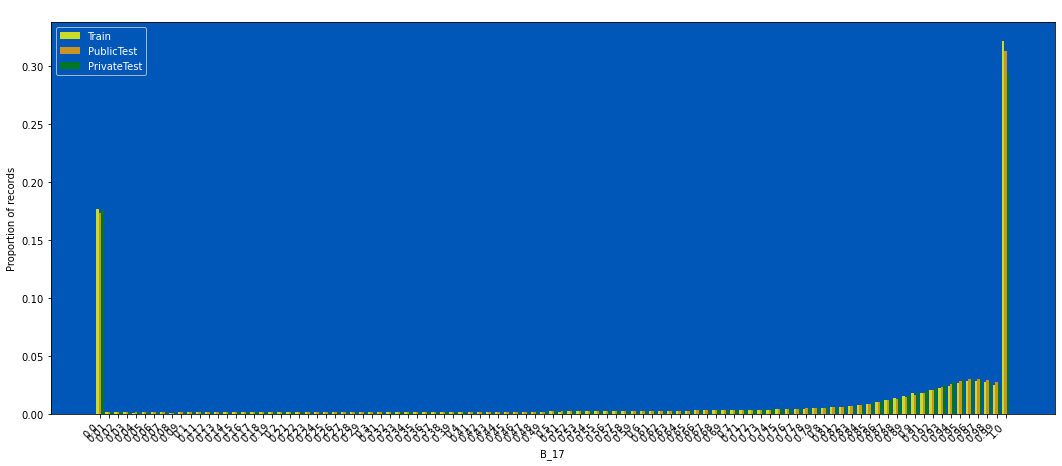

In [118]:
plot_train_test_distribution(df_list, "B_17", nunique_thr=8000)

### B_18

In [119]:
# plot_target_check(train, "B_18", q=50, use_raw_bin=True)

In [120]:
%%time
df_list = round_dfs(df_list, col="B_18", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0036
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0033
CPU times: user 2.4 s, sys: 1.92 s, total: 4.32 s
Wall time: 6.29 s


In [124]:
for df in df_list:
    df["B_18"] = (df["B_18"] / 0.05).round(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


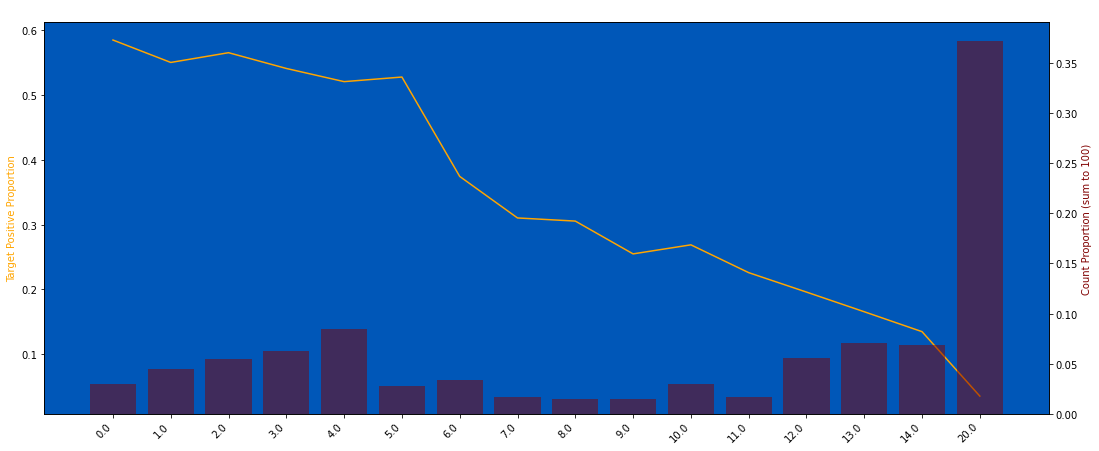

In [125]:
plot_target_check(train, "B_18", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [126]:
# plot_train_test_distribution(df_list, "B_18", nunique_thr=8000)

### B_19

In [127]:
# plot_target_check(train, "B_19", q=50, use_raw_bin=True)

In [128]:
%%time
df_list = round_dfs(df_list, col="B_19", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0023
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0022
CPU times: user 2.62 s, sys: 1.86 s, total: 4.49 s
Wall time: 6.17 s


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


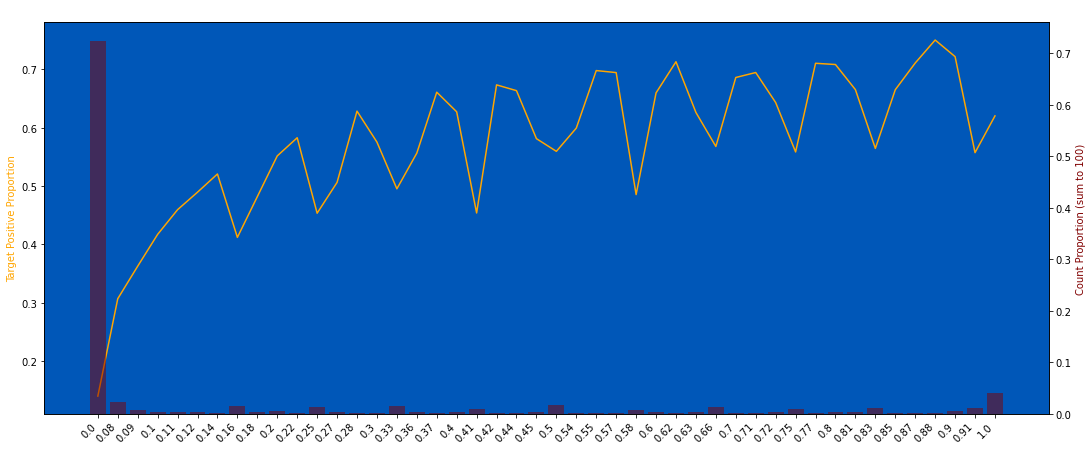

In [129]:
plot_target_check(train, "B_19", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [130]:
%%time
for df in df_list:
    df["B_19_"] = (df["B_19"] / 0.0799)
df_list = round_dfs(df_list, col="B_19_", decimals=0, add_new_col=False)

Before round, Train-Private PSI = 0.0022
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0008
CPU times: user 1.52 s, sys: 940 ms, total: 2.46 s
Wall time: 3.21 s


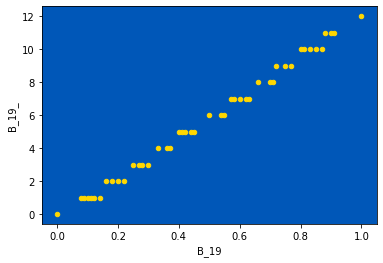

In [131]:
check_binning(train, "B_19", end=500000)

In [132]:
for df in df_list:
    df["B_19"] = (df["B_19"] / 0.0799)
df_list = round_dfs(df_list, col="B_19", decimals=0, add_new_col=False)

Before round, Train-Private PSI = 0.0022
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0008


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


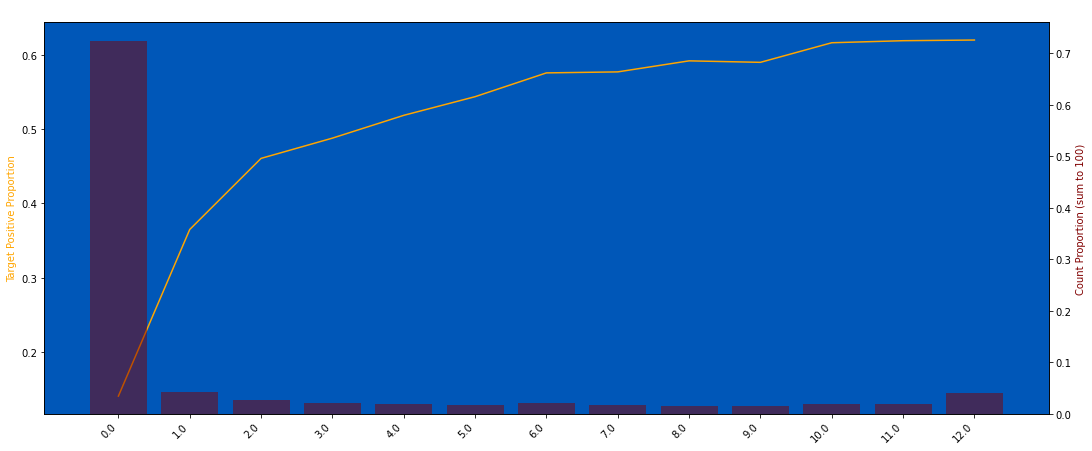

In [133]:
plot_target_check(train, "B_19", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0014, Train-Private PSI: 0.0008
Bottom 1% and Top 1% are dropped from this chart


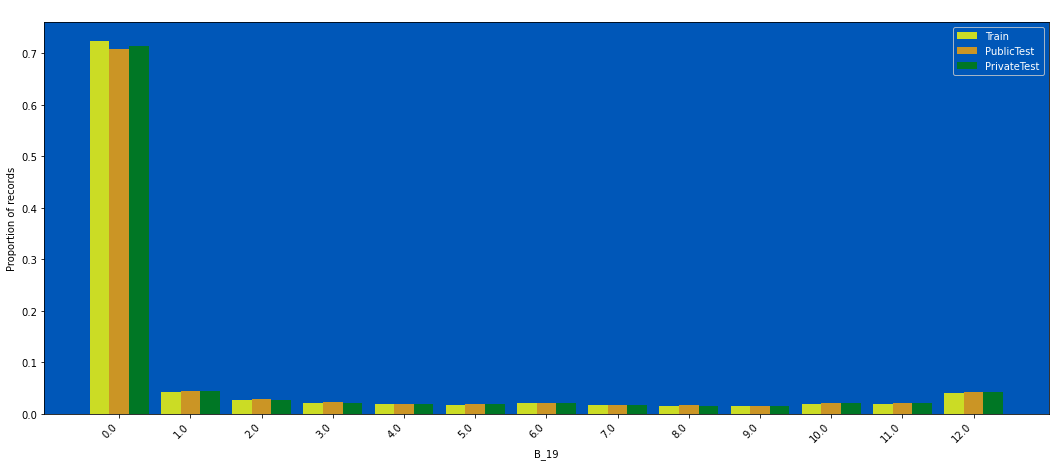

In [134]:
plot_train_test_distribution(df_list, "B_19", nunique_thr=8000)

### B_20

In [135]:
# plot_target_check(train, "B_20", q=50, use_raw_bin=True)

In [136]:
%%time
df_list = round_dfs(df_list, col="B_20", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0026
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0025
CPU times: user 2.66 s, sys: 1.86 s, total: 4.52 s
Wall time: 6.34 s


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


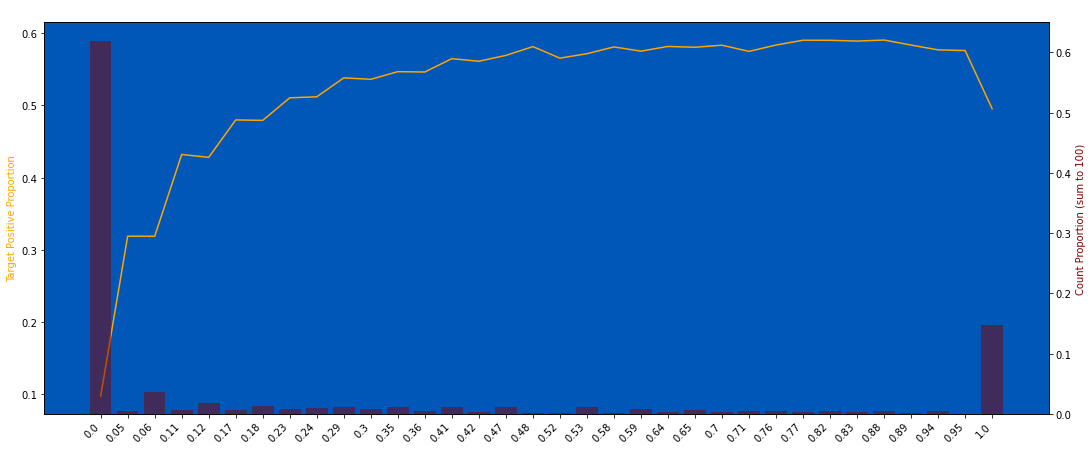

In [137]:
plot_target_check(train, "B_20", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [138]:
%%time
for df in df_list:
    df["B_20_"] = (df["B_20"] / 0.06).round(0)

CPU times: user 254 ms, sys: 61.8 ms, total: 316 ms
Wall time: 123 ms


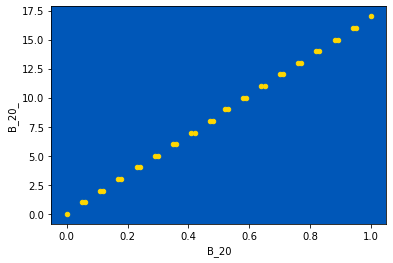

In [139]:
check_binning(train, "B_20", end=1000000)

In [140]:
for df in df_list:
    df["B_20"] = (df["B_20"] / 0.06).round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


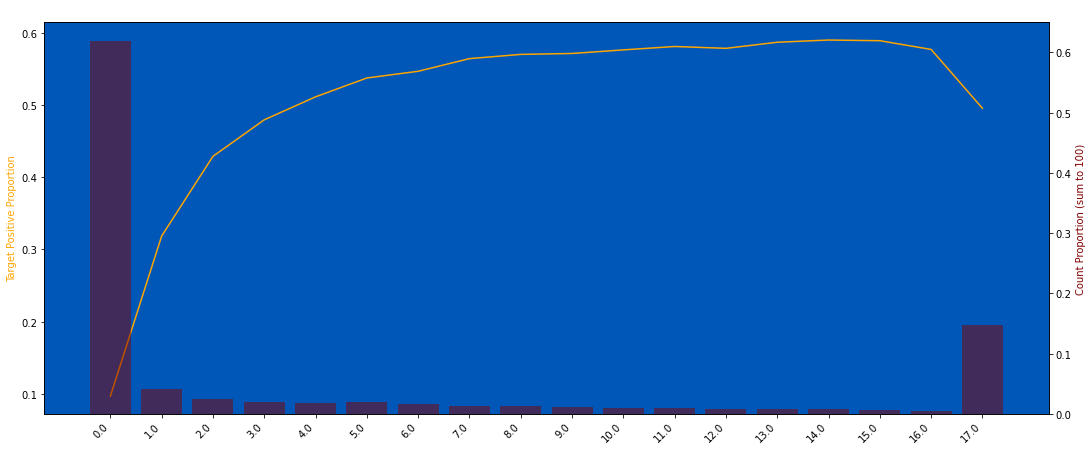

In [141]:
plot_target_check(train, "B_20", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0020, Train-Private PSI: 0.0025
Bottom 1% and Top 1% are dropped from this chart


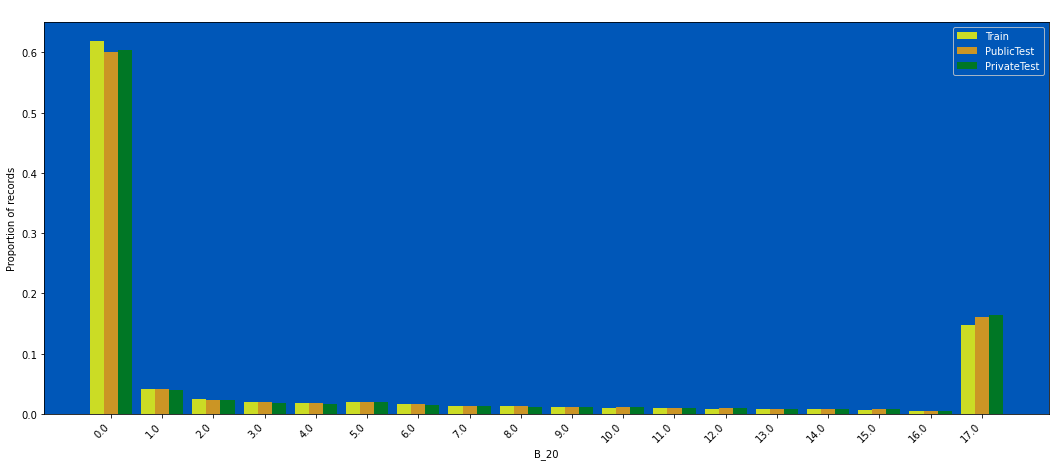

In [142]:
plot_train_test_distribution(df_list, "B_20", nunique_thr=8000)

### B_21

In [143]:
# plot_target_check(train, "B_21", q=50, use_raw_bin=True)

In [144]:
%%time
df_list = round_dfs(df_list, col="B_21", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0573
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0589
CPU times: user 2.56 s, sys: 1.93 s, total: 4.49 s
Wall time: 6.09 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


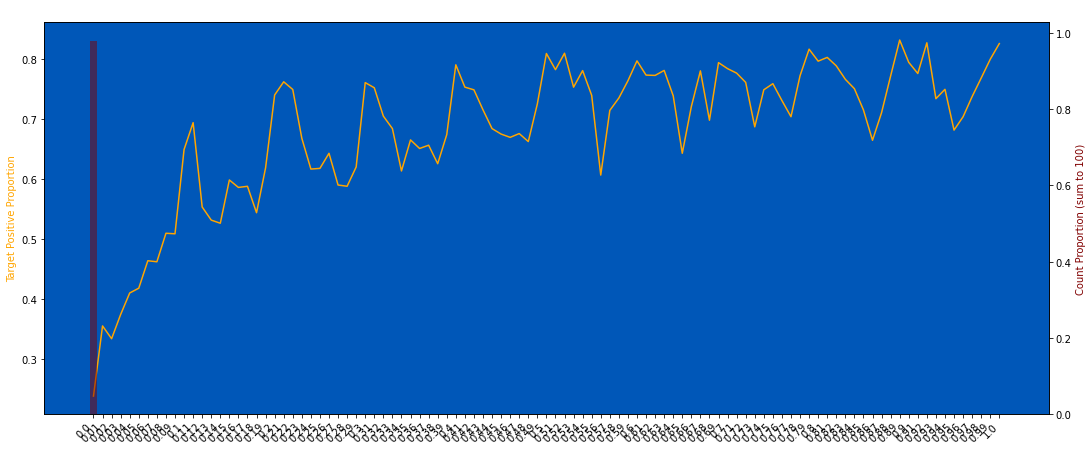

In [145]:
plot_target_check(train, "B_21", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [146]:
%%time
for df in df_list:
    df["B_21_"] = ((df["B_21"] - 0.01) / 0.1)
df_list = round_dfs(df_list, col="B_21_", decimals=0, add_new_col=False)

Before round, Train-Private PSI = 0.0589
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0518
CPU times: user 728 ms, sys: 998 ms, total: 1.73 s
Wall time: 2.78 s


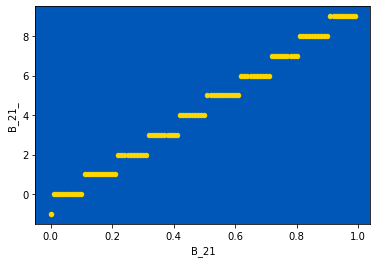

In [147]:
check_binning(train, "B_21", end=100)

In [148]:
for df in df_list:
    df["B_21"] = ((df["B_21"] - 0.01) / 0.1)
df_list = round_dfs(df_list, col="B_21", decimals=0, add_new_col=False)

Before round, Train-Private PSI = 0.0589
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0518


In [149]:
for df in df_list:
    df["B_21"] += 1

0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


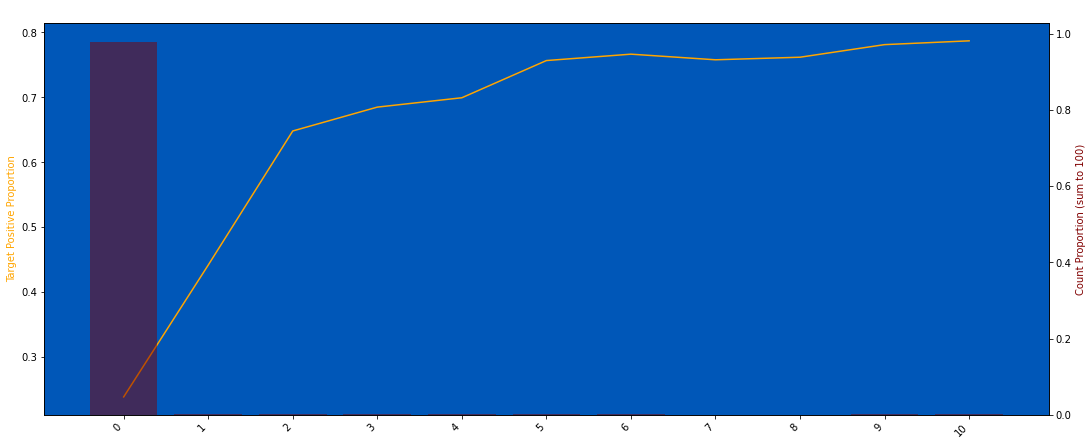

In [150]:
plot_target_check(train, "B_21", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [151]:
# plot_train_test_distribution(df_list, "B_21", nunique_thr=8000)

### B_22

In [152]:
# plot_target_check(train, "B_22", q=50, use_raw_bin=True, nunique_thr=7000)

In [153]:
%%time
df_list = round_dfs(df_list, col="B_22", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0015
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0003
CPU times: user 2.41 s, sys: 2.73 s, total: 5.13 s
Wall time: 5.75 s


In [154]:
for df in df_list:
    df["B_22"] *= 2

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


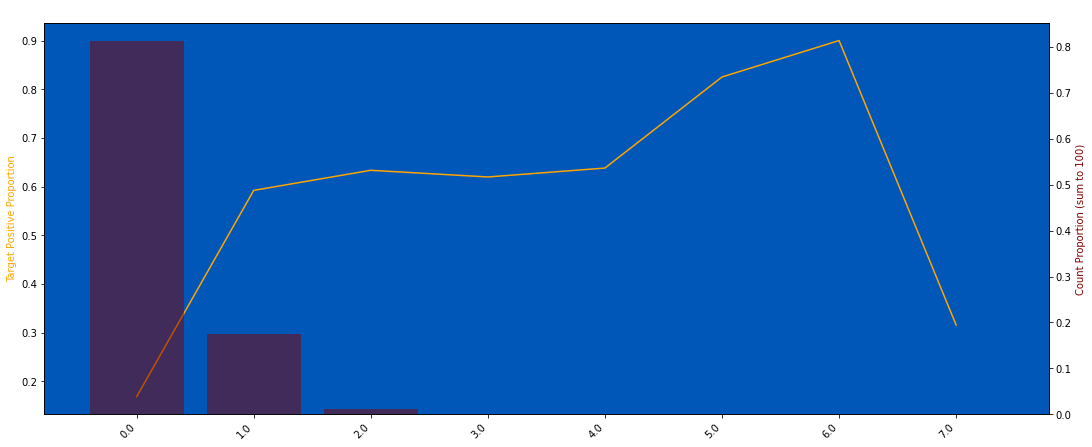

In [155]:
plot_target_check(train, "B_22", q=50, use_raw_bin=True, nunique_thr=7000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0009, Train-Private PSI: 0.0003


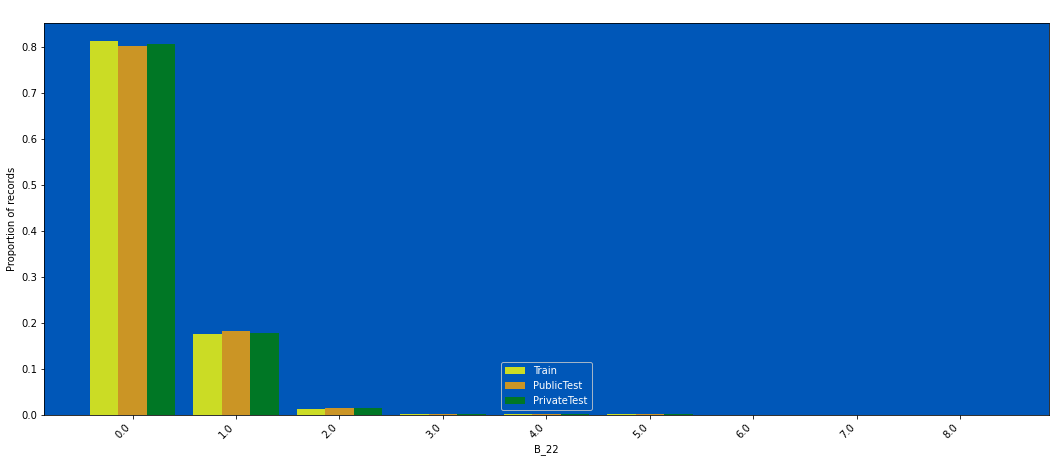

In [156]:
plot_train_test_distribution(df_list, "B_22", nunique_thr=8000, without_drop_tail=True)

### B_23

In [157]:
# plot_target_check(train, "B_23", q=50, use_raw_bin=True)

In [158]:
%%time
df_list = round_dfs(df_list, col="B_23", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0181
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0065
CPU times: user 2.78 s, sys: 1.56 s, total: 4.33 s
Wall time: 5.81 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


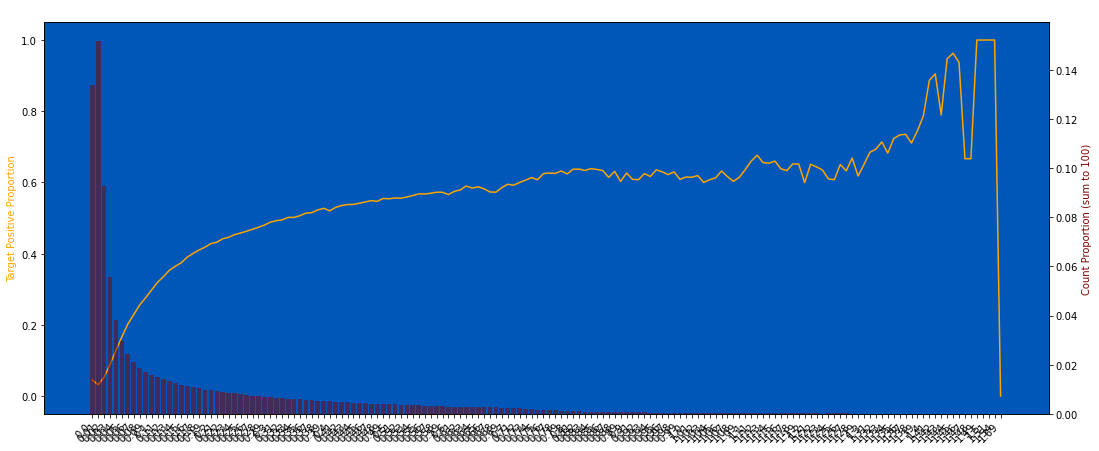

In [159]:
plot_target_check(train, "B_23", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0046, Train-Private PSI: 0.0065


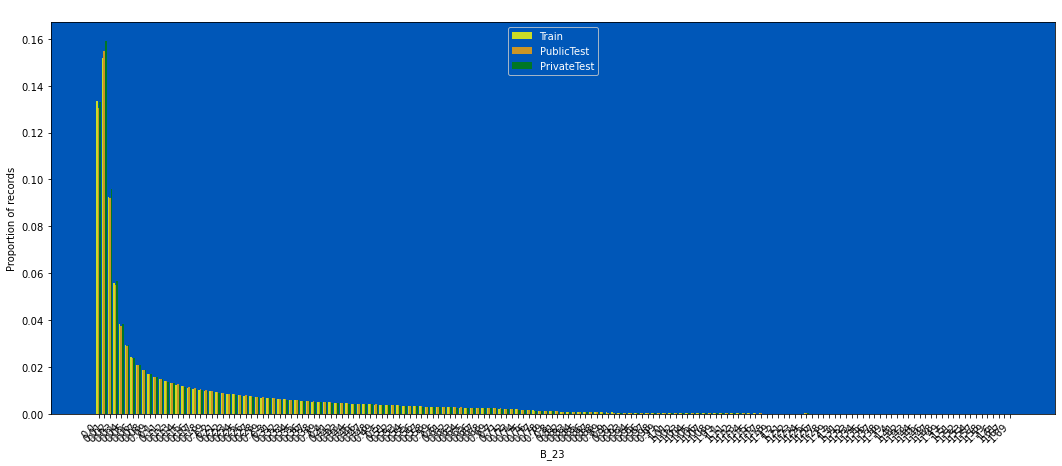

In [160]:
plot_train_test_distribution(df_list, "B_23", nunique_thr=5000, without_drop_tail=True)

### B_24

In [161]:
# plot_target_check(train, "B_24", q=50, use_raw_bin=True)

In [162]:
%%time
df_list = round_dfs(df_list, col="B_24", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0775
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0757
CPU times: user 2.23 s, sys: 1.6 s, total: 3.83 s
Wall time: 5.77 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


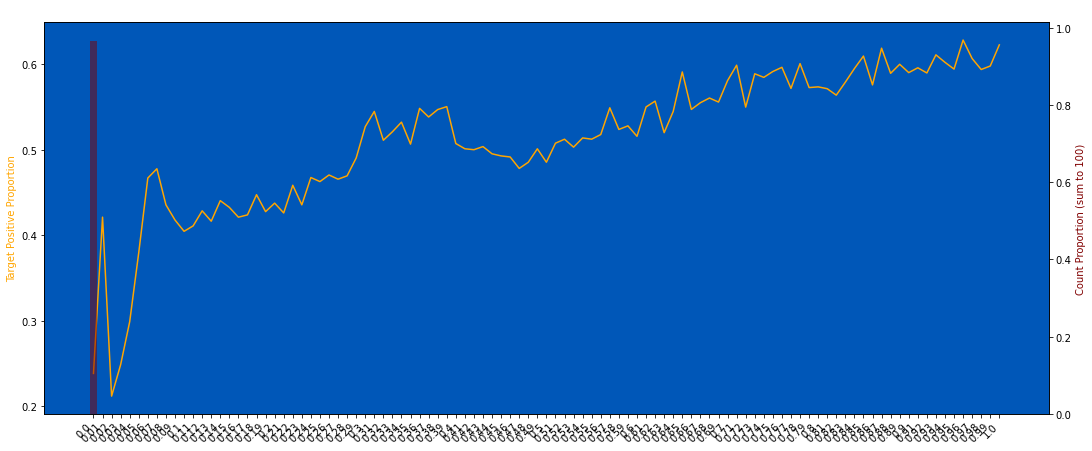

In [163]:
plot_target_check(train, "B_24", q=200, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [164]:
%%time
for df in df_list:
    df["B_24_"] = (df["B_24"] / 0.05).round(0)

CPU times: user 21.6 ms, sys: 34.3 ms, total: 55.9 ms
Wall time: 55.4 ms


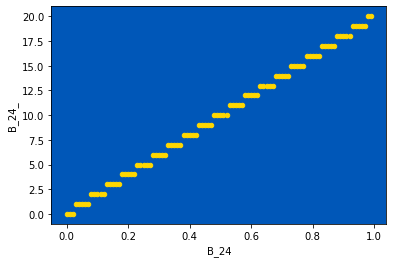

In [165]:
check_binning(train, "B_24", end=100)

In [166]:
for df in df_list:
    df["B_24"] = (df["B_24"] / 0.05).round(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


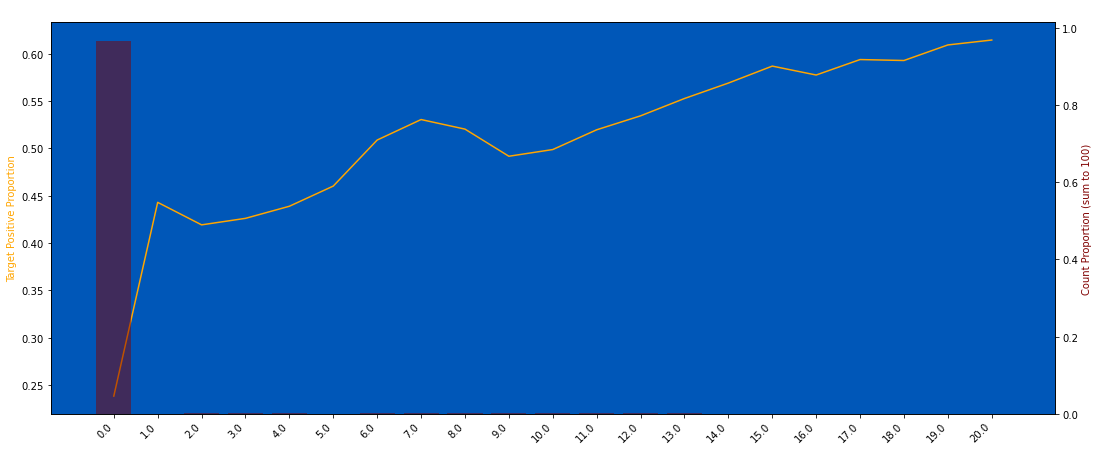

In [167]:
plot_target_check(train, "B_24", q=200, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0860, Train-Private PSI: 0.0741
Bottom 1% and Top 1% are dropped from this chart


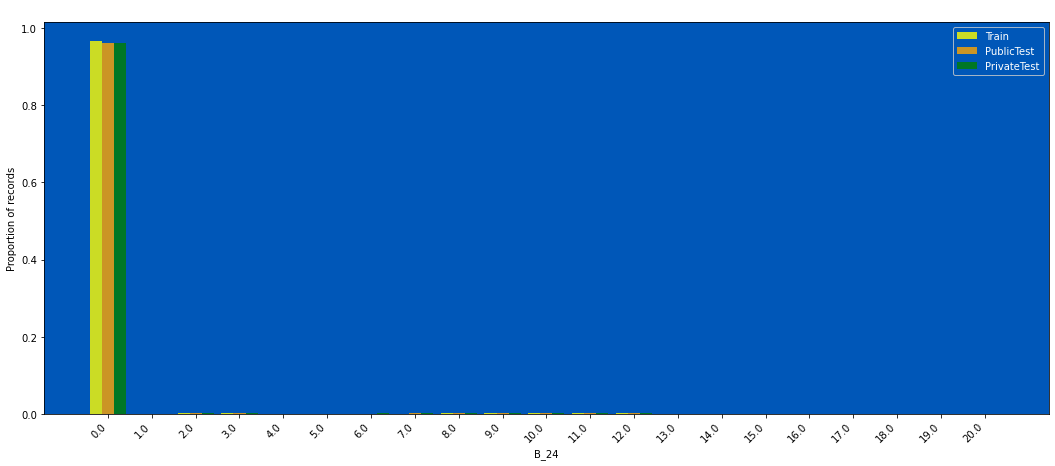

In [168]:
plot_train_test_distribution(df_list, "B_24", nunique_thr=8000)

### B_25

In [169]:
# plot_target_check(train, "B_25", q=50, use_raw_bin=True)

In [170]:
%%time
df_list = round_dfs(df_list, col="B_25", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0663
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0706
CPU times: user 2.8 s, sys: 1.56 s, total: 4.36 s
Wall time: 5.95 s


6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


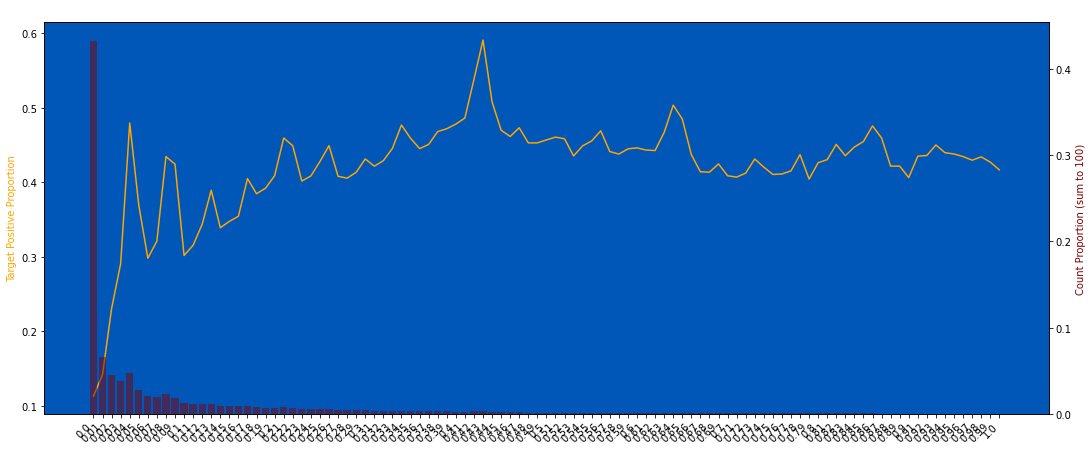

In [171]:
plot_target_check(train, "B_25", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0672, Train-Private PSI: 0.0706
Bottom 1% and Top 1% are dropped from this chart


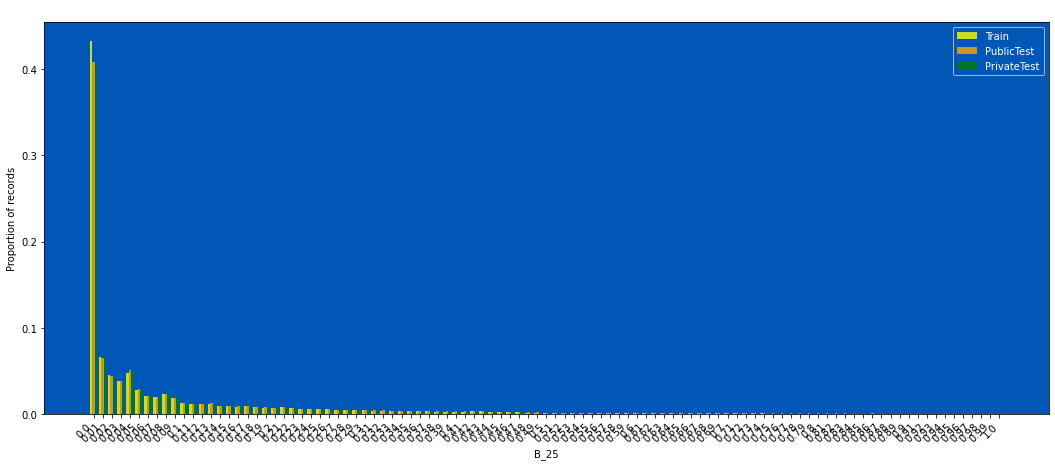

In [172]:
plot_train_test_distribution(df_list, "B_25", nunique_thr=8000)

### B_26

In [173]:
# plot_target_check(train, "B_26", q=50, use_raw_bin=True)

In [174]:
%%time
df_list = round_dfs(df_list, col="B_26", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0622
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0622
CPU times: user 2.24 s, sys: 1.42 s, total: 3.66 s
Wall time: 5.44 s


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


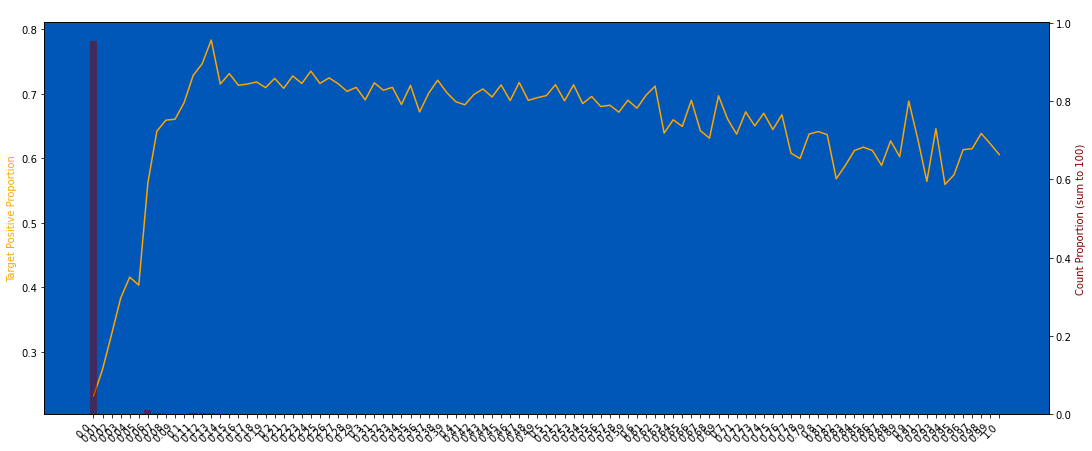

In [175]:
plot_target_check(train, "B_26", q=100, use_raw_bin=True, nunique_thr=35000, strfy_x=True)

Train-Public PSI: 0.0617, Train-Private PSI: 0.0622
Bottom 1% and Top 1% are dropped from this chart


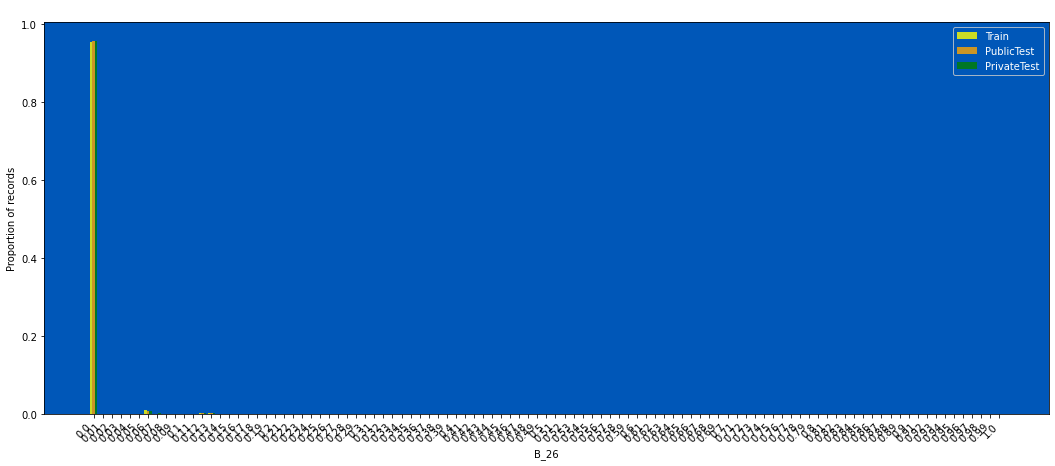

In [176]:
plot_train_test_distribution(df_list, "B_26", nunique_thr=8000)

### B_27 (Done)

In [177]:
# plot_target_check(train, "B_27", q=50, use_raw_bin=True)

In [178]:
%%time
df_list = round_dfs(df_list, col="B_27", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0425
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0096
CPU times: user 2.19 s, sys: 1.61 s, total: 3.8 s
Wall time: 5.73 s


In [179]:
# plot_target_check(train, "B_27", q=500, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [180]:
for df in df_list:
    df["B_27"] = np.where(df["B_27"] > 0, 1, 0)

In [181]:
# plot_target_check(train, "B_27", q=500, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0000, Train-Private PSI: 0.0000


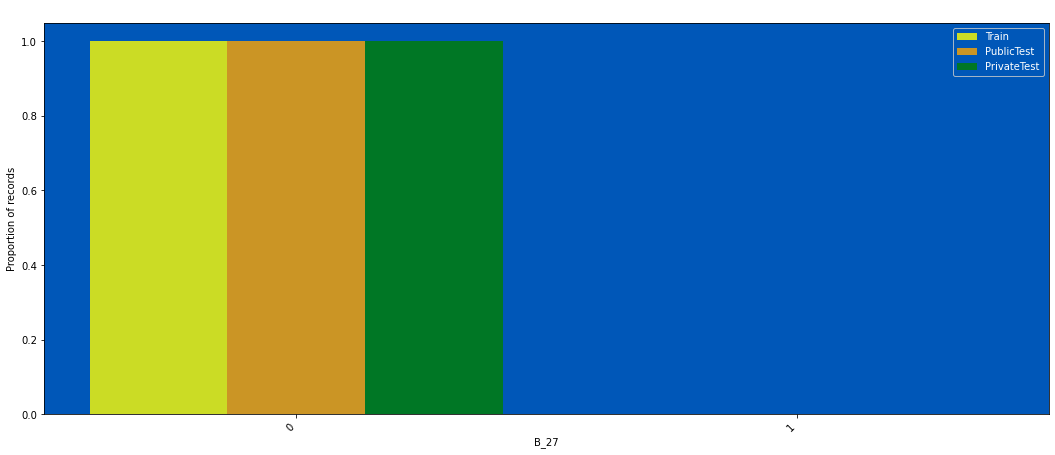

In [182]:
plot_train_test_distribution(df_list, "B_27", nunique_thr=8000, without_drop_tail=True)

### B_28

In [183]:
# plot_target_check(train, "B_28", q=50, use_raw_bin=True)

In [184]:
%%time
df_list = round_dfs(df_list, col="B_28", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0822
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0781
CPU times: user 2.75 s, sys: 1.51 s, total: 4.26 s
Wall time: 5.96 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


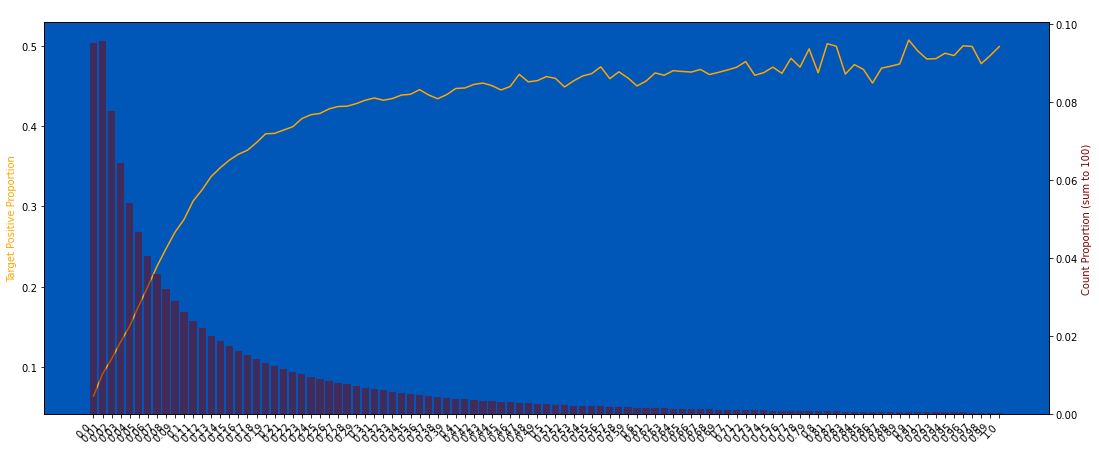

In [185]:
plot_target_check(train, "B_28", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Train-Public PSI: 0.0838, Train-Private PSI: 0.0781
Bottom 1% and Top 1% are dropped from this chart


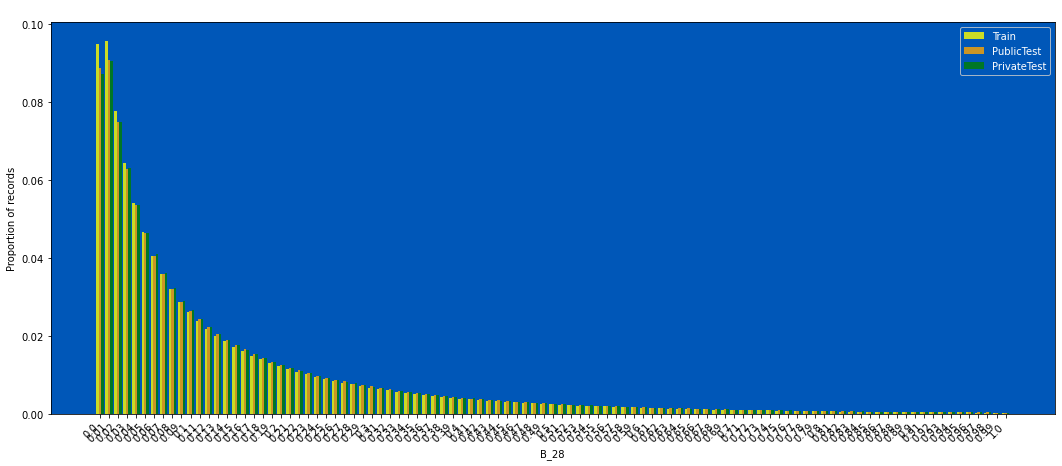

In [186]:
plot_train_test_distribution(df_list, "B_28", nunique_thr=8000)

### B_29 (Drop due to null count drift)

In [187]:
# plot_target_check(train, "B_29", q=50, use_raw_bin=True)

In [188]:
# %%time
# df_list = round_dfs(df_list, col="B_29", decimals=2, add_new_col=False)

In [189]:
describe_all(df_list, "B_29")

,train,public test,private test
count,"381,416.0000","362,382.0000","2,474,217.0000"
mean,0.0330,0.0396,0.0104
std,0.2765,0.3089,0.1243
min,0.0000,0.0000,0.0000
25%,0.0026,0.0026,0.0025
50%,0.0051,0.0051,0.0050
75%,0.0076,0.0077,0.0075
max,12.0240,16.0477,13.1487
null_proportion,0.9310,0.9366,0.5616


In [190]:
# plot_target_check(train, "B_29", q=150, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [191]:
# plot_train_test_distribution(df_list, "B_29", nunique_thr=8000)

In [192]:
for df in df_list:
    df.drop(columns="B_29", errors="ignore", inplace=True)

### B_30

In [193]:
# plot_target_check(train, "B_30", q=50, use_raw_bin=True, without_drop_tail=True)

Train-Public PSI: 0.0006, Train-Private PSI: 0.0004


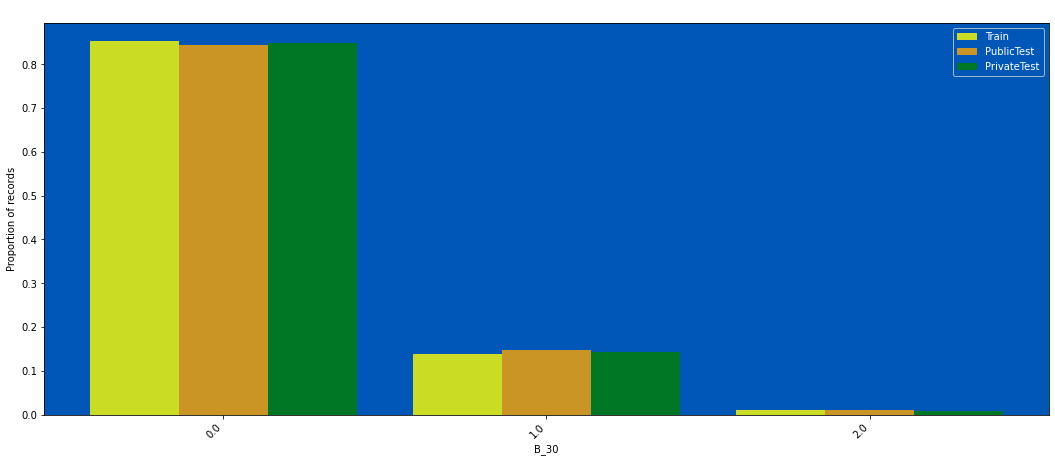

In [194]:
plot_train_test_distribution(df_list, "B_30", nunique_thr=8000, without_drop_tail=True)

### B_31

In [195]:
# plot_target_check(train, "B_31", q=50, use_raw_bin=True, nunique_thr=3, without_drop_tail=True)

In [196]:
# plot_train_test_distribution(df_list, "B_31", nunique_thr=8000, without_drop_tail=True)

In [197]:
for df in tqdm(df_list):
    df.drop("B_31", axis=1, errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:13<00:00,  4.50s/it]


### B_32 (Done)

In [198]:
# plot_target_check(train, "B_32", q=50, use_raw_bin=True)

In [199]:
%%time
df_list = round_dfs(df_list, col="B_32", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0010
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0010
CPU times: user 2.36 s, sys: 2.38 s, total: 4.74 s
Wall time: 7.72 s


In [200]:
# plot_target_check(train, "B_32", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0004, Train-Private PSI: 0.0010


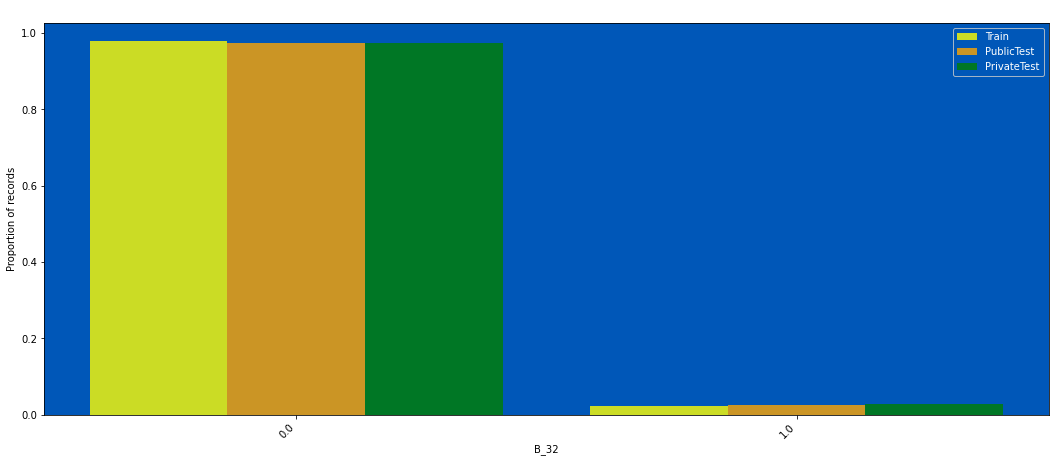

In [201]:
plot_train_test_distribution(df_list, "B_32", nunique_thr=8000, without_drop_tail=True)

### B_33 (Done)

In [202]:
# plot_target_check(train, "B_33", q=50, use_raw_bin=True)

In [203]:
%%time
df_list = round_dfs(df_list, col="B_33", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0006
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0006
CPU times: user 2.82 s, sys: 2.11 s, total: 4.93 s
Wall time: 7.25 s


In [204]:
# plot_target_check(train, "B_33", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0010, Train-Private PSI: 0.0006


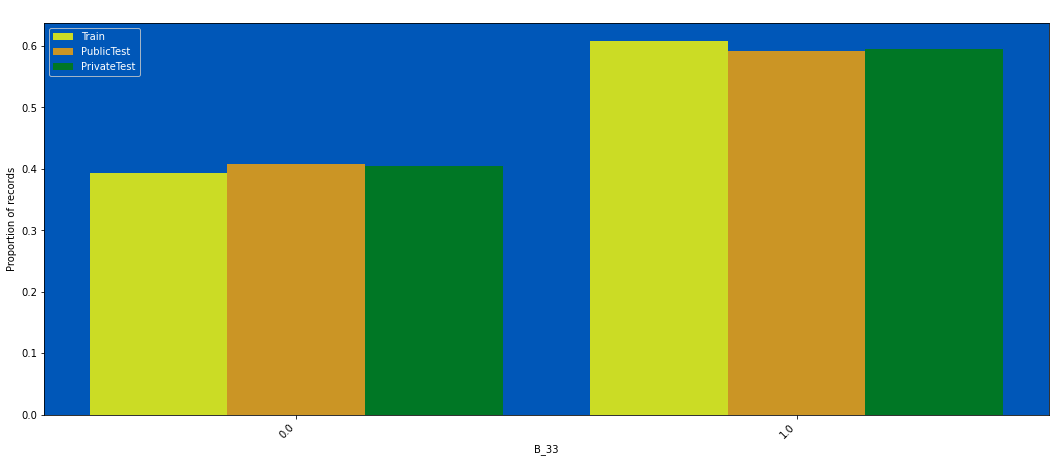

In [205]:
plot_train_test_distribution(df_list, "B_33", nunique_thr=8000, without_drop_tail=True)

### B_36 (Done)

In [206]:
# plot_target_check(train, "B_36", q=50, use_raw_bin=True)

In [207]:
%%time
df_list = round_dfs(df_list, col="B_36", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1501
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0166
CPU times: user 2.97 s, sys: 2.33 s, total: 5.3 s
Wall time: 7.07 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


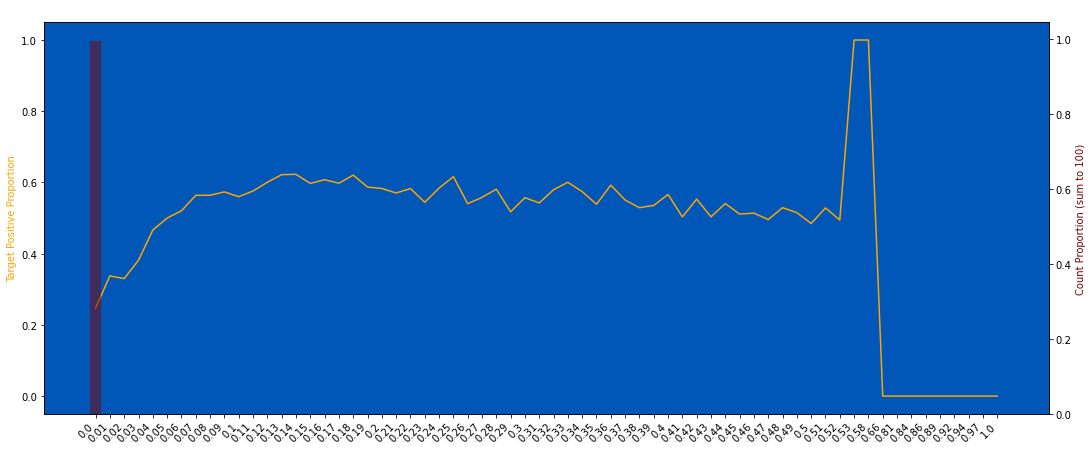

In [208]:
plot_target_check(train, "B_36", q=100, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [209]:
for df in df_list:
    df["B_36"] = np.where(df["B_36"] > 0, 1, 0)

In [210]:
# plot_target_check(train, "B_36", q=100, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0024, Train-Private PSI: 0.0030


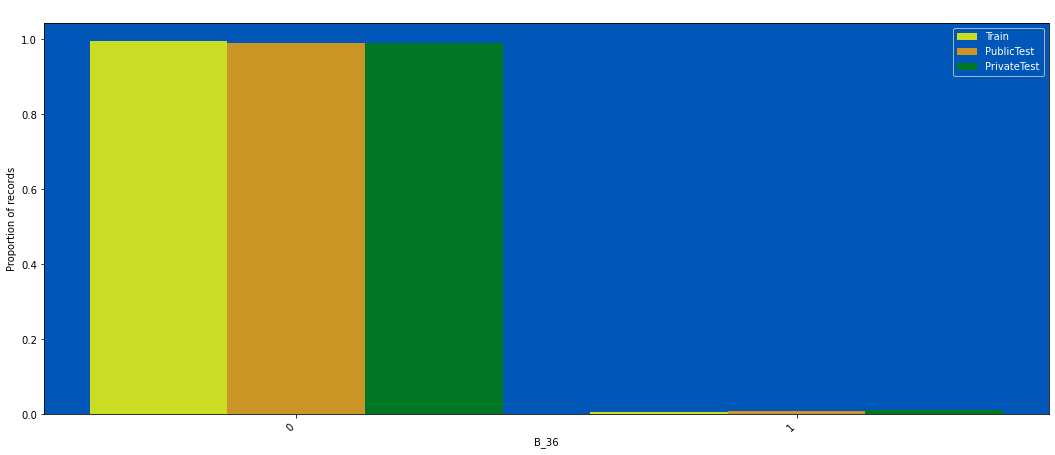

In [211]:
plot_train_test_distribution(df_list, "B_36", nunique_thr=8000, without_drop_tail=True)

In [212]:
gc.collect()

58401

### B_37

In [213]:
# plot_target_check(train, "B_37", q=50, use_raw_bin=True)

In [214]:
%%time
df_list = round_dfs(df_list, col="B_37", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0644
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0625
CPU times: user 2.76 s, sys: 2.37 s, total: 5.14 s
Wall time: 7.74 s


56 null count, 0.000 null proportion
0.1964 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


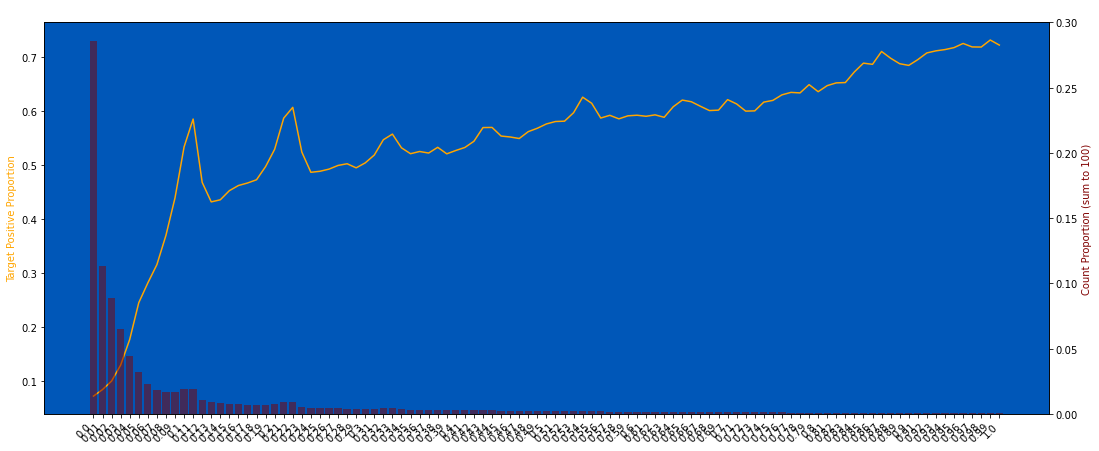

In [215]:
plot_target_check(train, "B_37", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

### B_38

In [216]:
mapping = dict(train.groupby(["B_38"])["target"].mean())
mapping

{1.0: 0.13526434704800755,
 2.0: 0.0633063558246025,
 3.0: 0.32860357758809544,
 4.0: 0.6997155131782841,
 5.0: 0.5594304673871995,
 6.0: 0.6149160701061467,
 7.0: 0.49886498756891146}

In [217]:
for df in df_list:
    df["B_38"] = df["B_38"].map(mapping)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


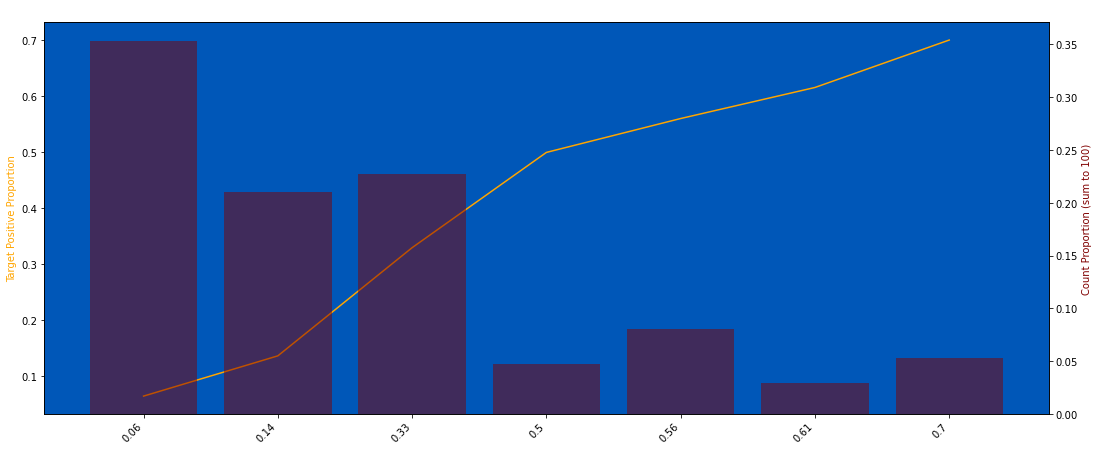

In [218]:
plot_target_check(train, "B_38", q=50, use_raw_bin=True, nunique_thr=50, strfy_x=True, without_drop_tail=True)

In [219]:
for df in df_list:
    df["B_38"] = df["B_38"].astype("category").cat.codes
    df["B_38"] = df["B_38"].replace(-1, 0)

Train-Public PSI: 0.0046, Train-Private PSI: 0.0158


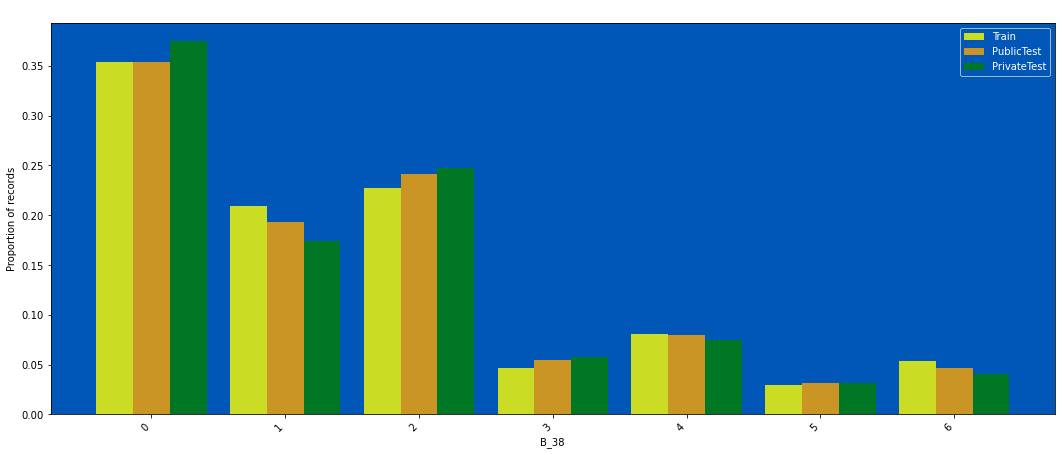

In [220]:
plot_train_test_distribution(df_list, "B_38", nunique_thr=1000, without_drop_tail=True)

### B_39

In [221]:
# plot_target_check(train, "B_39", q=50, use_raw_bin=True)

In [222]:
%%time
df_list = round_dfs(df_list, col="B_39", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0367
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0268
CPU times: user 1.61 s, sys: 2.23 s, total: 3.84 s
Wall time: 6.79 s


5497819 null count, 0.994 null proportion
0.2473 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


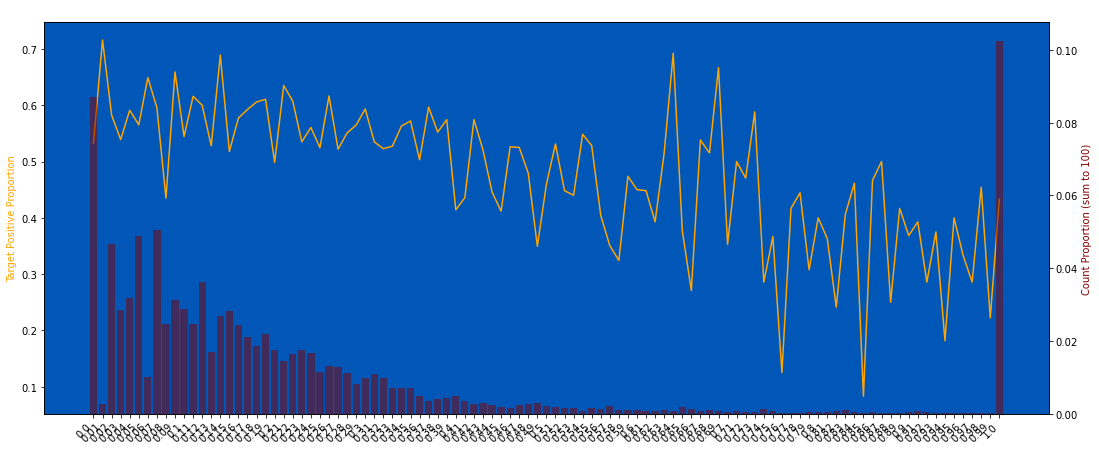

In [223]:
plot_target_check(train, "B_39", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0191, Train-Private PSI: 0.0268
Bottom 1% and Top 1% are dropped from this chart


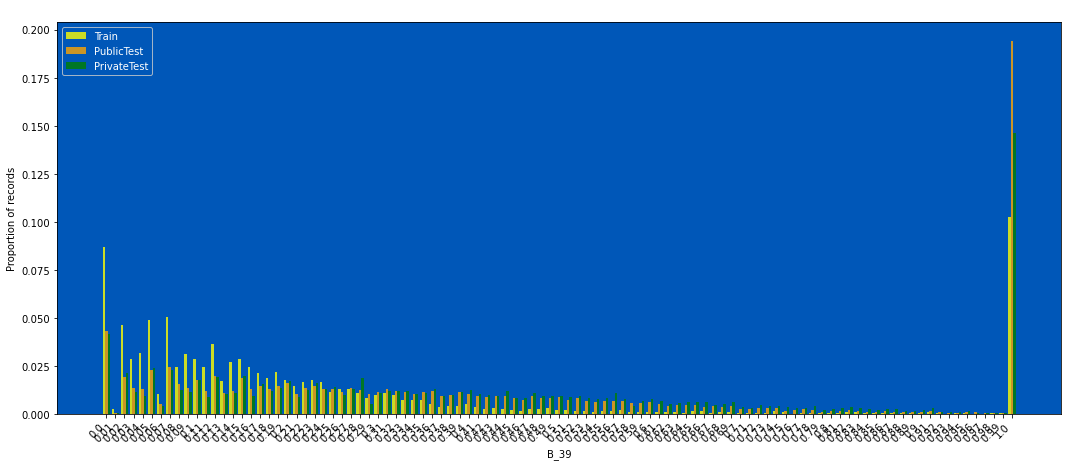

In [224]:
plot_train_test_distribution(df_list, "B_39", nunique_thr=1000)

In [225]:
for df in df_list:
    df.drop(columns=["B_39"], errors="ignore", inplace=True)

### B_40

In [226]:
# plot_target_check(train, "B_40", q=50, use_raw_bin=True)

In [227]:
%%time
df_list = round_dfs(df_list, col="B_40", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0444
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0444
CPU times: user 2.5 s, sys: 2.28 s, total: 4.78 s
Wall time: 7.74 s


53 null count, 0.000 null proportion
0.1698 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


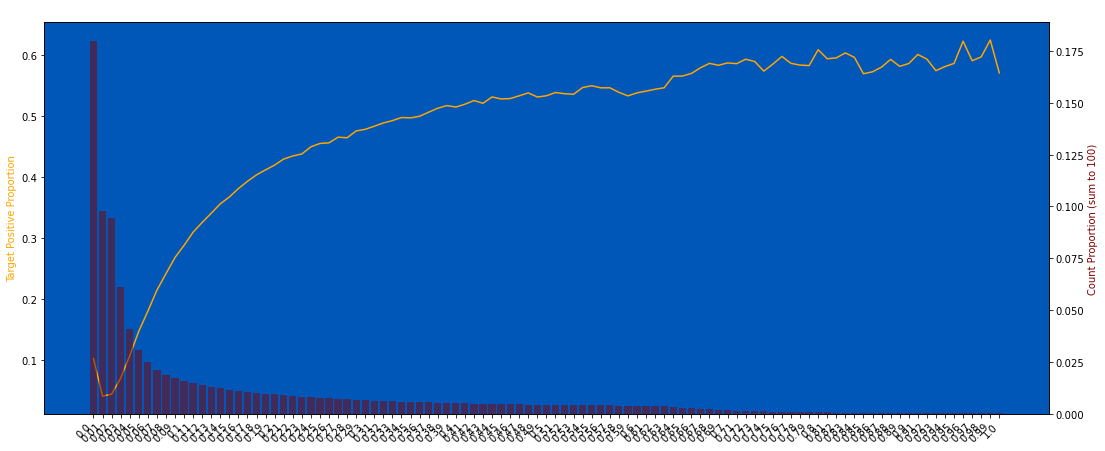

In [228]:
plot_target_check(train, "B_40", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0282, Train-Private PSI: 0.0444
Bottom 1% and Top 1% are dropped from this chart


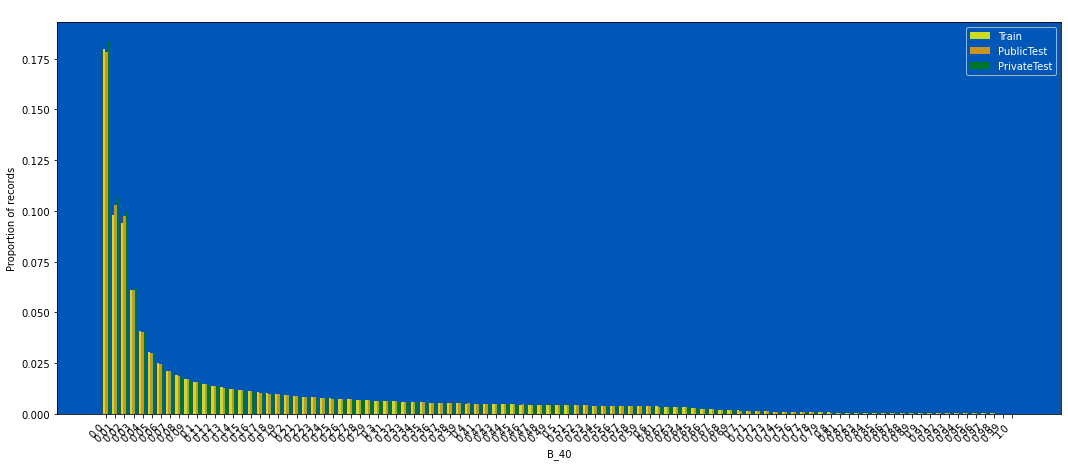

In [229]:
plot_train_test_distribution(df_list, "B_40", nunique_thr=5000)

### B_41

In [230]:
# plot_target_check(train, "B_41", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [231]:
%%time
df_list = round_dfs(df_list, col="B_41", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0024
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0018
CPU times: user 2.27 s, sys: 2.11 s, total: 4.38 s
Wall time: 6.95 s


690 null count, 0.000 null proportion
0.1420 of the targets have label = 1


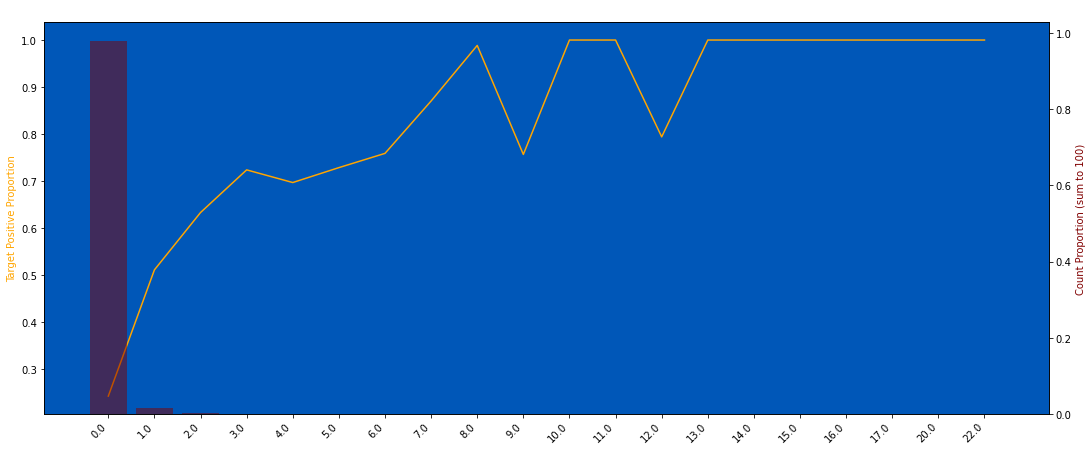

In [232]:
plot_target_check(train, "B_41", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [233]:
for df in df_list:
    df["B_41"] = np.where(df["B_41"] > 3, 3, df["B_41"])

690 null count, 0.000 null proportion
0.1420 of the targets have label = 1


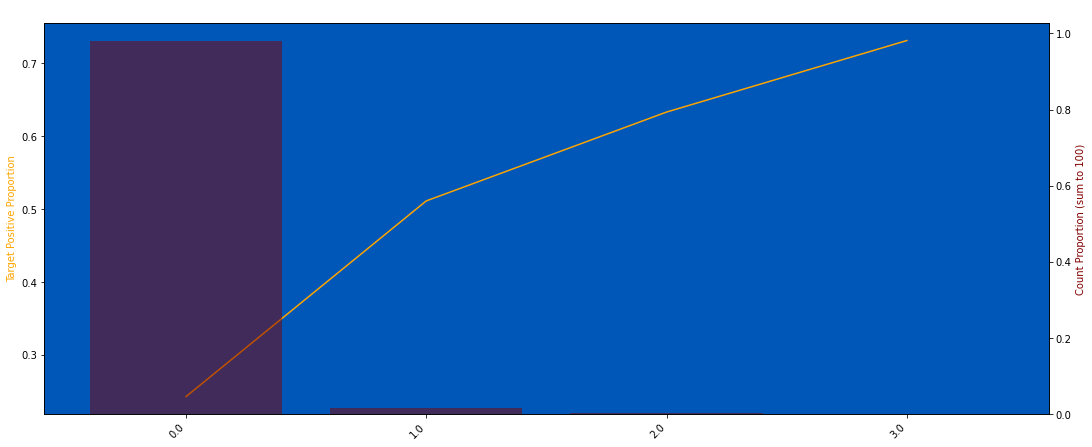

In [234]:
plot_target_check(train, "B_41", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0002, Train-Private PSI: 0.0004


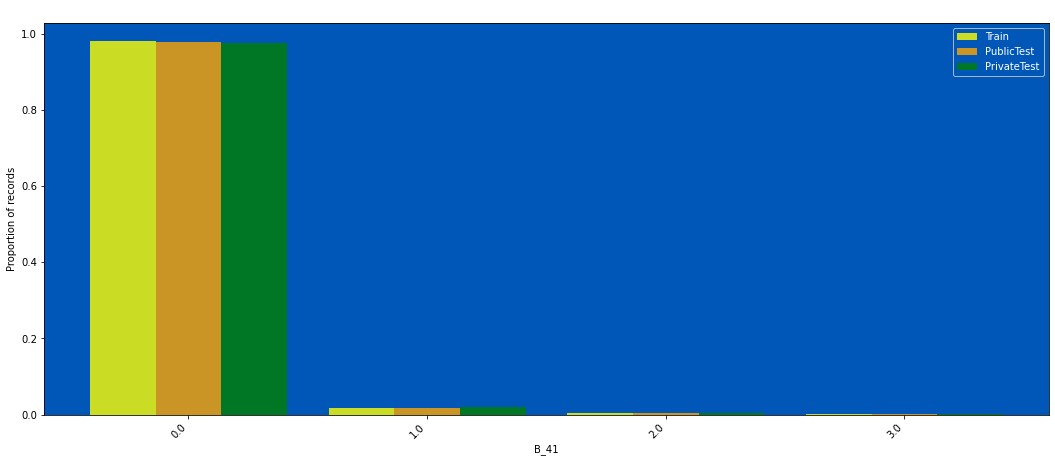

In [235]:
plot_train_test_distribution(df_list, "B_41", nunique_thr=100, without_drop_tail=True)

### B_42

In [236]:
# plot_target_check(train, "B_42", q=50, use_raw_bin=True)

In [237]:
%%time
df_list = round_dfs(df_list, col="B_42", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1140
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1099
CPU times: user 1.45 s, sys: 2.09 s, total: 3.55 s
Wall time: 5.95 s


5459973 null count, 0.987 null proportion
0.2508 of the targets have label = 1


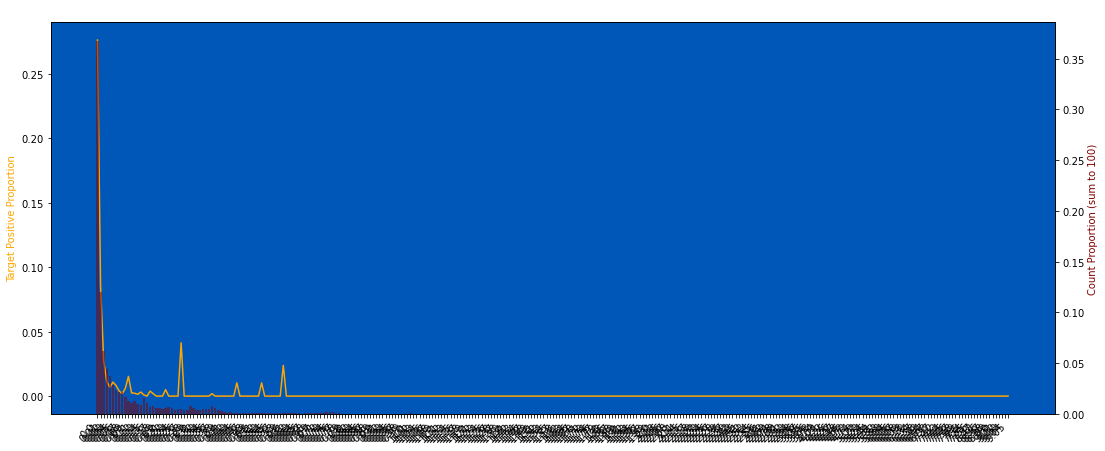

In [238]:
plot_target_check(train, "B_42", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.1209, Train-Private PSI: 0.1099
Bottom 1% and Top 1% are dropped from this chart


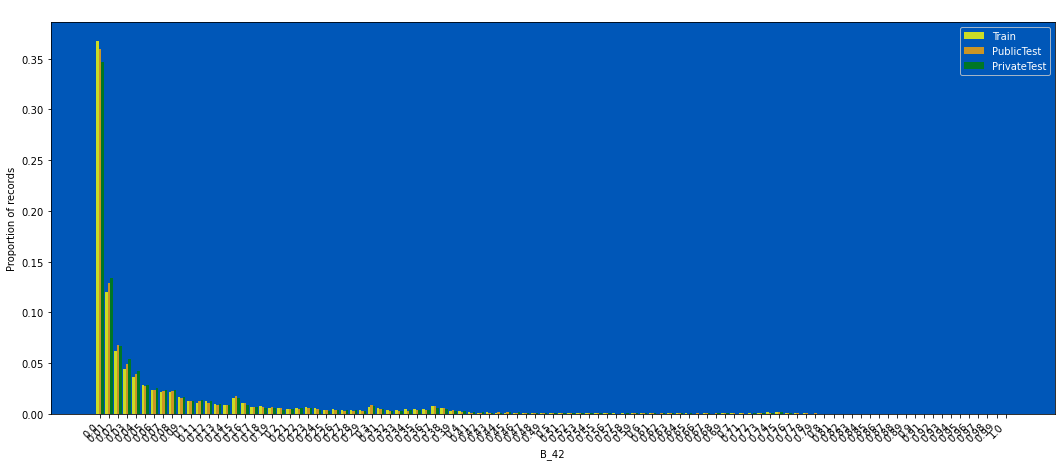

In [239]:
plot_train_test_distribution(df_list, "B_42", nunique_thr=300)

### Column checking

In [241]:
all_columns = get_cols(df_list[0], ["B_"])
print(all_columns)

['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_40', 'B_41', 'B_42', 'B_723', 'B_111', 'B_137', 'B_16_', 'B_18_', 'B_19_', 'B_20_', 'B_21_', 'B_24_']


In [242]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()

In [243]:
print(less_unique_d_cols)

['B_8', 'B_16', 'B_18', 'B_19', 'B_20', 'B_22', 'B_27', 'B_30', 'B_32', 'B_33', 'B_36', 'B_38', 'B_41', 'B_16_', 'B_18_', 'B_19_', 'B_20_']


In [244]:
for col in less_unique_d_cols:
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

B_8 fulfill criteria to convert to integer
B_16 fulfill criteria to convert to integer
B_18 fulfill criteria to convert to integer
B_19 fulfill criteria to convert to integer
B_20 fulfill criteria to convert to integer
B_22 fulfill criteria to convert to integer
B_27 fulfill criteria to convert to integer
B_30 fulfill criteria to convert to integer
B_32 fulfill criteria to convert to integer
B_33 fulfill criteria to convert to integer
B_36 fulfill criteria to convert to integer
B_38 fulfill criteria to convert to integer
B_41 fulfill criteria to convert to integer
B_16_ fulfill criteria to convert to integer
B_18_ fulfill criteria to convert to integer
B_19_ fulfill criteria to convert to integer
B_20_ fulfill criteria to convert to integer


In [245]:
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

B_1 fulfill criteria to convert to float32
B_2 fulfill criteria to convert to float32
B_3 fulfill criteria to convert to float32
B_4 fulfill criteria to convert to float32
B_5 fulfill criteria to convert to float32
B_6 fulfill criteria to convert to float32
B_7 fulfill criteria to convert to float32
B_9 fulfill criteria to convert to float32
B_10 fulfill criteria to convert to float32
B_11 fulfill criteria to convert to float32
B_12 fulfill criteria to convert to float32
B_13 fulfill criteria to convert to float32
B_14 fulfill criteria to convert to float32
B_15 fulfill criteria to convert to float32
B_17 fulfill criteria to convert to float32
B_23 fulfill criteria to convert to float32
B_24 fulfill criteria to convert to float32
B_25 fulfill criteria to convert to float32
B_26 fulfill criteria to convert to float32
B_28 fulfill criteria to convert to float32
B_37 fulfill criteria to convert to float32
B_40 fulfill criteria to convert to float32
B_42 fulfill criteria to convert to floa

In [248]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [247]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]

CPU times: user 760 ms, sys: 1.33 s, total: 2.09 s
Wall time: 2.25 s


In [249]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 4.54 s, sys: 4.02 s, total: 8.57 s
Wall time: 13.1 s


In [250]:
train.shape, test.shape

((5531451, 45), (11363762, 44))

In [251]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.797721591, 3.511402602)

In [252]:
%%time
train.to_parquet(f"./train_parquet/train_balance_.parquet")
test.to_parquet(f"./test_parquet/test_balance_.parquet")

CPU times: user 13.3 s, sys: 1.68 s, total: 14.9 s
Wall time: 14.6 s


In [253]:
END = time.time()

In [254]:
print(f"{END - START:.2f} seconds elapsed")

858.60 seconds elapsed
